In [1]:
%matplotlib inline
%precision 3

import os
import re
import datetime

import numpy as np
np.set_printoptions(precision=3)
np.random.seed(123)
from numpy.random import randn
from numpy import nan as NA

import pandas as pd
pd.options.display.max_rows = 6

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from pandas.plotting import autocorrelation_plot
from pylab import pcolor, show, colorbar, xticks, yticks
from matplotlib.ticker import PercentFormatter

import seaborn as sns


In [2]:
!powershell -command "& {gc NCDB_1999_to_2014.csv -head 6}"

C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
1999,01,1,20,2,02,34,UU,1,5,3,03,01,06,1990,01,M,41,11,1,UU,1
1999,01,1,20,2,02,34,UU,1,5,3,03,02,01,1987,01,M,19,11,1,UU,1
1999,01,1,20,2,02,34,UU,1,5,3,03,02,01,1987,02,F,20,13,2,02,2
1999,01,1,08,2,01,01,UU,5,3,6,18,01,01,1986,01,M,46,11,1,UU,1
1999,01,1,08,2,01,01,UU,5,3,6,18,99,NN,NNNN,01,M,05,99,2,UU,3


In [3]:
accident = pd.read_csv('NCDB_1999_to_2014.csv', engine = 'python')

In [4]:
#Replace all column head to lower case.
accident.columns = accident.columns.map(lambda x: x[:].lower())
accident

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
0,1999,01,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,01,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,01,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860402,2014,UU,U,14,2,01,02,01,1,5,...,01,01,2006,01,F,UU,11,2,01,1
5860403,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,01,M,67,12,3,01,U
5860404,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,02,M,10,98,1,01,U


In [5]:
#Check the non-numeric values in date-time columns
accident[accident['c_mnth'].str.contains('[^0-9]')|
         accident['c_wday'].str.contains('[^0-9]')|
         accident['c_hour'].str.contains('[^0-9]')]

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
128,1999,01,1,UU,2,02,33,02,1,1,...,01,06,1990,01,M,57,11,1,02,1
129,1999,01,1,UU,2,02,33,02,1,1,...,02,01,1991,01,M,18,11,2,02,1
175,1999,01,1,UU,2,01,03,UU,1,4,...,01,01,1989,01,M,30,11,2,02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860402,2014,UU,U,14,2,01,02,01,1,5,...,01,01,2006,01,F,UU,11,2,01,1
5860403,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,01,M,67,12,3,01,U
5860404,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,02,M,10,98,1,01,U


#### Data cleaning and normalization

In [6]:
#Remove all special values (unknown to us) in date-time columns, prepare for using date series as index.
#Make a copy "df" for further analysis, avoid mess up the original data "accident".

df = accident[:]
df[['c_mnth','c_wday','c_hour']] = df[['c_mnth','c_wday','c_hour']].replace('[^0-9]+',np.nan,regex=True)
df.dropna(axis=0,subset=['c_mnth','c_wday','c_hour'],inplace=True)

df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
0,1999,01,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,01,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,01,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860378,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,01,F,35,11,2,02,1
5860379,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,02,M,26,13,1,02,2
5860380,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,03,F,15,21,2,02,2


In [7]:
#Generate the date-time column "date", which could be assigned as index later.
#Notes: 'dfp' using 'PeriodIndex' to generate monthly index, which meke better sense, but very slow.
dfp=df[:]
df['date'] = pd.DatetimeIndex(df['c_year'].map(str) + '-' + df['c_mnth'])
dfp['date'] = pd.PeriodIndex(dfp['c_year'].map(str) + '-' + dfp['c_mnth'], freq='M')

df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user,date
0,1999,01,1,20,2,02,34,UU,1,5,...,06,1990,01,M,41,11,1,UU,1,1999-01-01
1,1999,01,1,20,2,02,34,UU,1,5,...,01,1987,01,M,19,11,1,UU,1,1999-01-01
2,1999,01,1,20,2,02,34,UU,1,5,...,01,1987,02,F,20,13,2,02,2,1999-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860378,2014,12,7,19,2,01,03,01,1,3,...,01,2001,01,F,35,11,2,02,1,2014-12-01
5860379,2014,12,7,19,2,01,03,01,1,3,...,01,2001,02,M,26,13,1,02,2,2014-12-01
5860380,2014,12,7,19,2,01,03,01,1,3,...,01,2001,03,F,15,21,2,02,2,2014-12-01


---
### 1 Collision Severity & Time
### 1.1) Trend over the whole period and seasonality identification

In [8]:
#From 'dfp' generating 'df_b', removed non-numeric strings from four other columns.
df_b = dfp[:]
df_b[['c_rcfg','c_wthr','c_rsur','c_traf']] =\
        df_b[['c_rcfg','c_wthr','c_rsur','c_traf']].replace('[^0-9]+',np.nan,regex=True)
df_b.dropna(axis=0,subset=['c_rcfg','c_wthr','c_rsur','c_traf'],inplace=True)

#This line use 'date' as index, meke 'df_b' becoming time series.
df_b = df_b.set_index('date')
df_b

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
date,,,,,,,,,,,,,,,,,,,,,
1999-01,1999,01,1,15,2,01,QQ,01,1,1,...,01,01,1995,01,M,17,11,1,02,1
1999-01,1999,01,1,15,2,01,QQ,01,1,1,...,99,NN,NNNN,02,F,41,99,2,NN,3
1999-01,1999,01,1,09,2,02,34,02,1,1,...,01,01,1992,01,F,33,11,2,02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,01,F,35,11,2,02,1
2014-12,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,02,M,26,13,1,02,2
2014-12,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,03,F,15,21,2,02,2


In [9]:
df_b['fatal']=np.where(df_b['c_sev']==1,1,0)
df_b['non_fatal']=np.where(df_b['c_sev']==2,1,0)

df1 = df_b.groupby('date')['fatal','non_fatal'].sum()
df1

,fatal,non_fatal
date,,
1999-01,335,25782
1999-02,365,20591
1999-03,519,23221
...,...,...
2014-10,367,22930
2014-11,287,20948
2014-12,281,19933


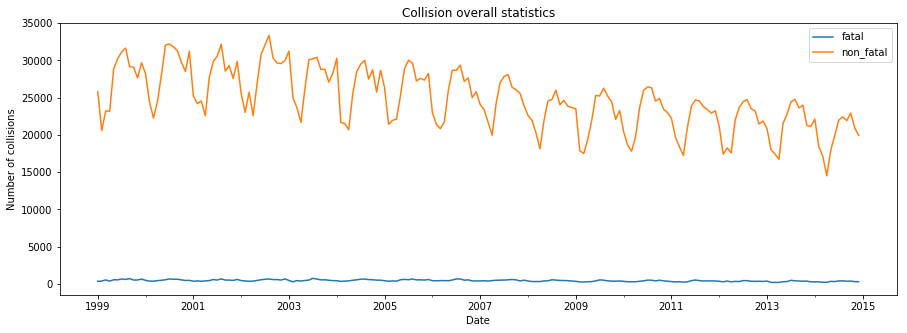

In [10]:
#The overall diagram
plot1 = df1.plot(figsize=(15,5),title='Collision overall statistics')
plot1.set_xlabel("Date")
plot1.set_ylabel("Number of collisions");

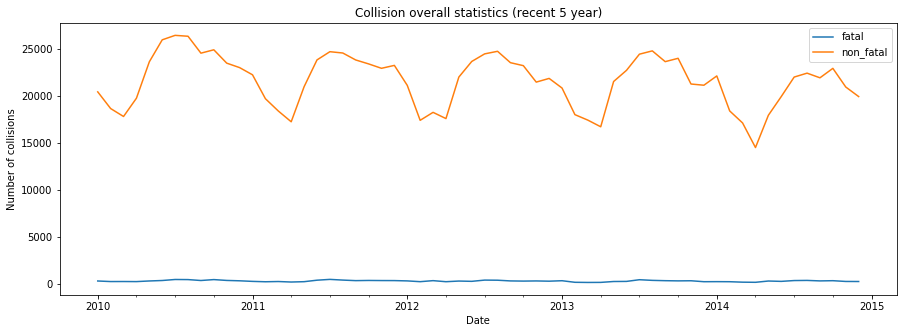

In [11]:
# Since the dateset period is 15 year, it's diffucult to identify a seasonality pattern in this scale
# Thus, a smaller period was selected to identify on-peak and off-peak of collisions
plot1 = df1[-60:].plot(figsize=(15,5),
                     title='Collision overall statistics (recent 5 year)')
plot1.set_xlabel("Date")
plot1.set_ylabel("Number of collisions");

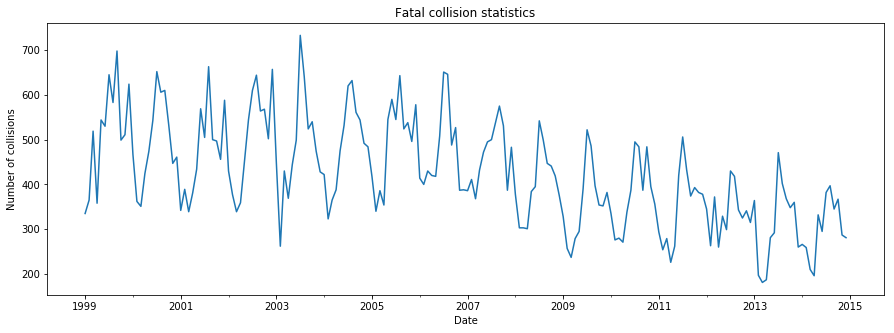

In [12]:
#Due to a huge difference in number of fatal and non-fatal collisions,
# fatal collisions trend was analyzed in its own scale.
#Overall statistics
plot2 = df1['fatal'].plot(figsize=(15,5),title='Fatal collision statistics')
plot2.set_xlabel("Date")
plot2.set_ylabel("Number of collisions");

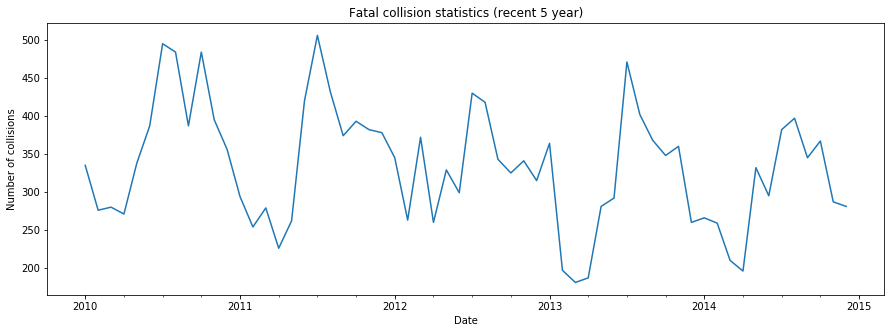

In [13]:
# Fatal collision statistics for the recent 5 years
plot1 = df1['fatal'][-60:].plot(figsize=(15,5),title='Fatal collision statistics (recent 5 year)')
plot1.set_xlabel("Date")
plot1.set_ylabel("Number of collisions");

#### Conslusion:
The  collision trend declines slightly over years and has pronounced seasonality pattern. The collision peak is in the middle of year and downturn is in Q1.

### 1.2) Correlation between total number of collisions and fatal collisions
Autocorrelation plot demostrates an obvious seasonality with period of 12 months.

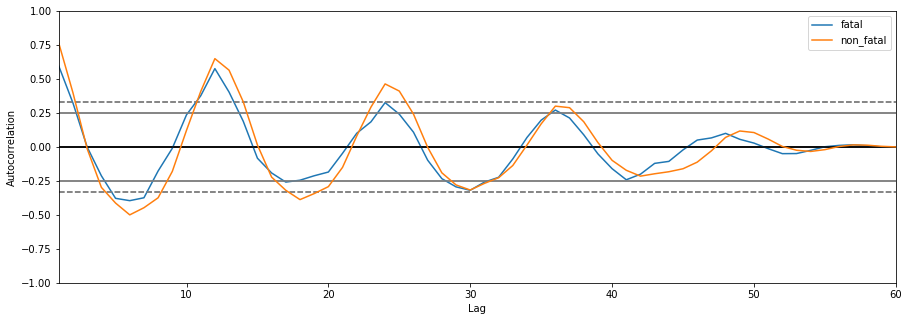

In [14]:
#To confirm the seasonality assumtion, the autocorrelation of fatal and
# non-fatal collisions was performed for the recent 5 years.
plt.figure(figsize=(15,5))
for c in df1.columns:
    autocorrelation_plot(df1[c][-60:],label=c);

#### Conlustion:
The fatal and non-fatal collisions have strong positive correlation.

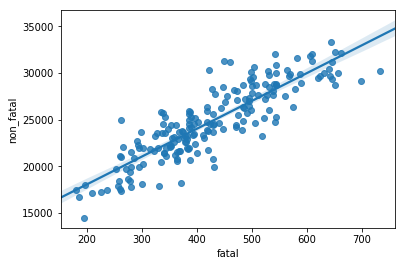

In [15]:
sns.regplot('fatal', 'non_fatal', data=df1);

#### Conclusion:
The  correlation coefficient between fatal and non fatal collisions is 0.87

In [16]:
corr = df1.corr()
corr

,fatal,non_fatal
fatal,1.000000,0.870378
non_fatal,0.870378,1.000000


---
### 2.Analysis of collision risk dependency on different week day and day hours

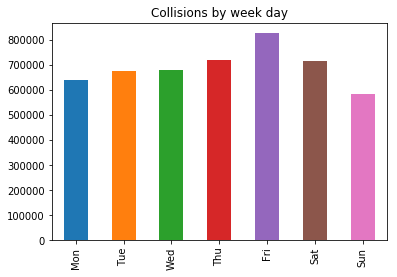

In [17]:
#Collisions by weekday
by_weekday = df_b.groupby('c_wday')['c_sev'].count()
by_weekday.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plot2 = by_weekday.plot(kind='bar',title='Collisions by week day');

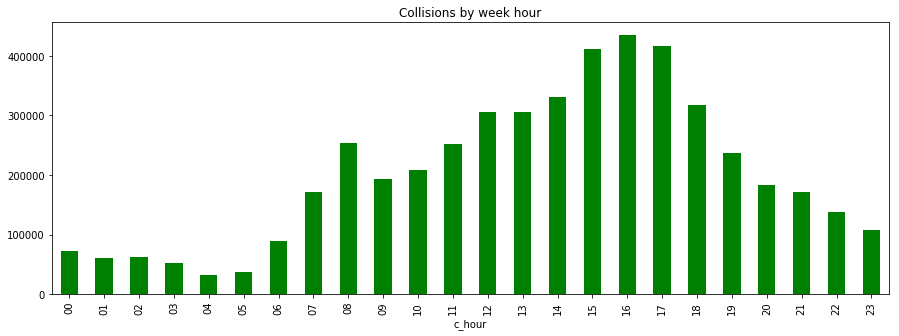

In [18]:
#Collisions by hour
plt.figure(figsize=(15,5))
by_hour = df_b.groupby('c_hour')['c_sev'].count()
plot3 = by_hour.plot(kind='bar',title='Collisions by week hour',color='G');

#### Conclusion: 
The higher collision risk is on Friday and the lowest is on Sunday.
The riskiest period is from 3 pm to 5 pm. Night hours have the lowest collision risk.

---
### 3.Analysis of the following factors to collision rate:
### 3.1) Road configuration

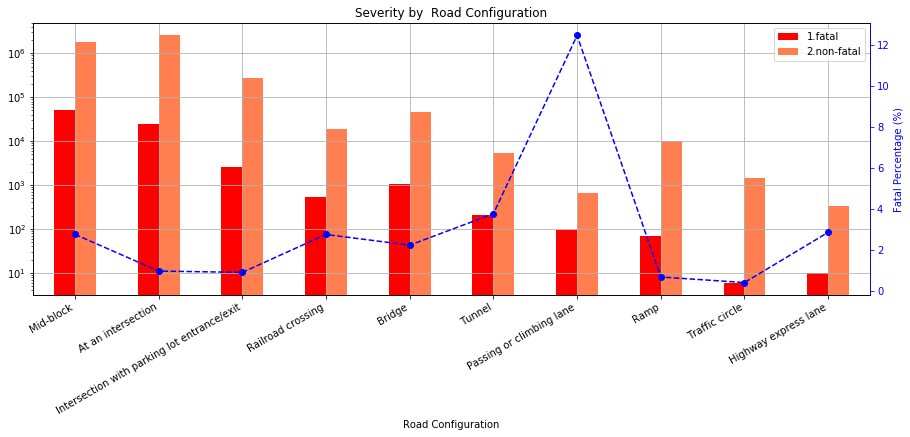

In [19]:
#Collisions severity by road configuration (c_rcfg field)
rcfg_type = ['Mid-block','At an intersection','Intersection with parking lot entrance/exit',
            'Railroad crossing','Bridge','Tunnel','Passing or climbing lane',
             'Ramp','Traffic circle','Highway express lane',
             'Highway collector lane','Highway transfer lane']

df2 = df_b.groupby(['c_rcfg','c_sev']).size().unstack().fillna(0)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

#Plot the new dataframe in logarithm, since the gap between numbers are huge.

df2.plot(kind='bar',rot=30,logy=True,color=['red','coral'],figsize=(15,5),
         title='Severity by  Road Configuration', ax=ax1)
ax1.grid(axis='both')
ax1.legend(['1.fatal','2.non-fatal'])
ax1.set_xticklabels(rcfg_type,ha='right')
ax1.set_xlabel('Road Configuration')

#Calculate the percentage of fatal injury in all accidents by different road surface type,
# and plot to right axis.
se1 = df2[1]/(df2[1]+df2[2])*100
se1.plot(c='b', style='o--', ax=ax2)

plt.xticks(np.arange(0,10),rcfg_type); 

#### Conclusion:
It was noticed that majority of collisions occur at mid-block and intersection, the fatality rate is very high in collisions with passing or climbing lane ~12%.
### 3.2) Weather

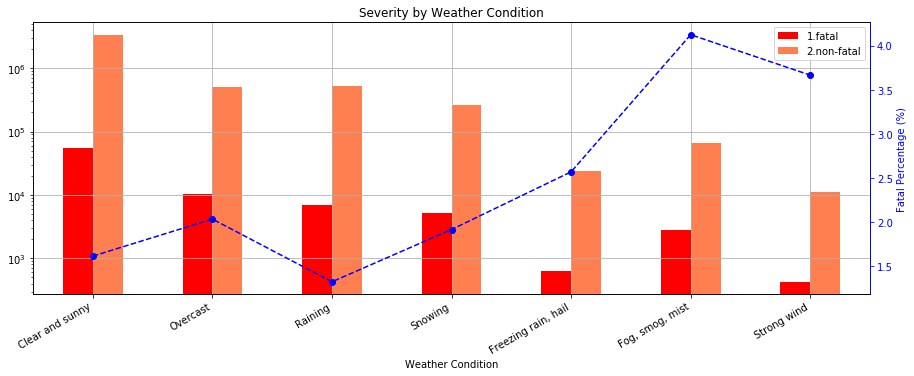

In [20]:
#Collisions severity  by Weather Condition  (c_wthr field)
wthr_type = ['Clear and sunny','Overcast','Raining','Snowing','Freezing rain, hail','Fog, smog, mist',
            'Strong wind']

df3 = df_b.groupby(['c_wthr','c_sev']).size().unstack().fillna(0)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

#Plot the new dataframe in logarithm, since the gap between numbers are huge.

df3.plot(kind='bar',rot=30,logy=True,color=['red','coral'],figsize=(15,5),
         title='Severity by Weather Condition', ax=ax1)
ax1.grid(axis='both')
ax1.legend(['1.fatal','2.non-fatal'])
ax1.set_xticklabels(wthr_type,ha='right')
ax1.set_xlabel('Weather Condition')

#Calculate the percentage of fatal injury in all accidents by different road surface type,
# and plot to right axis.
se1 = df3[1]/(df3[1]+df3[2])*100
se1.plot(c='b', style='o--', ax=ax2)

plt.xticks(np.arange(0,7),wthr_type); 

#### Conclusion:
It was noticed that majority of collisions occur on clean and sunny day. Howeverm a fatal collision rate is higher when visibility is limited (fog, mist) and when tehre is a strong wing. The fatality rate when last two conditions is about 4%.
### 3.3) Road surface

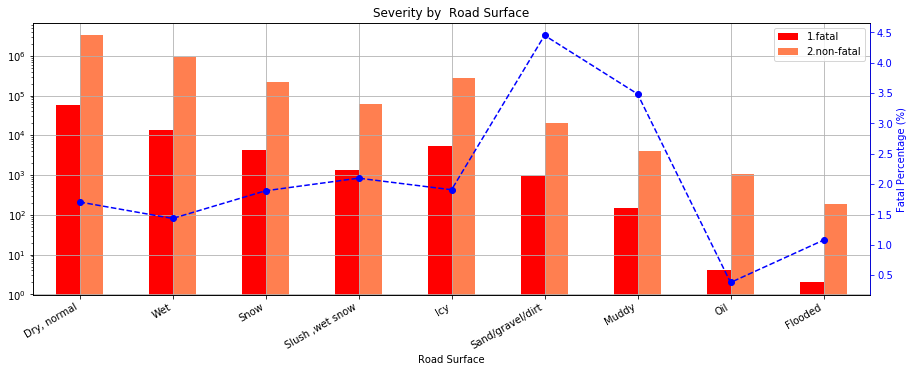

In [21]:
#Collision severity grouped by Road Surface (c_rsur field)
rsur_type = ['Dry, normal','Wet','Snow','Slush ,wet snow','Icy','Sand/gravel/dirt','Muddy','Oil','Flooded']

df4 = df_b.groupby(['c_rsur','c_sev']).size().unstack().fillna(0)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

#Plot the new dataframe in logarithm, since the gap between numbers are huge.

df4.plot(kind='bar',rot=30,logy=True,color=['red','coral'],figsize=(15,5),
         title='Severity by  Road Surface', ax=ax1)
ax1.grid(axis='both')
ax1.legend(['1.fatal','2.non-fatal'])
ax1.set_xticklabels(rsur_type,ha='right')
ax1.set_xlabel('Road Surface')

#Calculate the percentage of fatal injury in all accidents by different road surface type,
# and plot to right axis.
se1 = df4[1]/(df4[1]+df4[2])*100
se1.plot(c='b', style='o--', ax=ax2)

plt.xticks(np.arange(0,9),rsur_type); 

#### Conclusion:
While the most of collisions occur on dry and normal road, the fatal collision rate is higher on sandy, dirty and muddy road. The fatality rate is up to 4.5%.
### 3.4) Traffic control

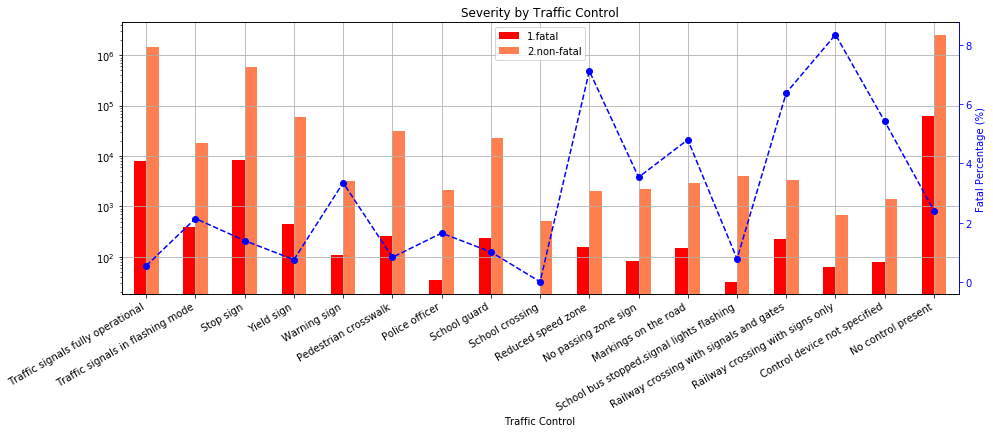

In [22]:
#Collisions severity  by Traffic Control (c_traf field)
traf_type = ['Traffic signals fully operational','Traffic signals in flashing mode',
             'Stop sign','Yield sign','Warning sign','Pedestrian crosswalk',
             'Police officer','School guard','School crossing','Reduced speed zone',
             'No passing zone sign','Markings on the road',
             'School bus stopped,signal lights flashing','Railway crossing with signals and gates',
             'Railway crossing with signs only','Control device not specified','No control present']

df5 = df_b.groupby(['c_traf','c_sev']).size().unstack().fillna(0)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

#Plot the new dataframe in logarithm, since the gap between numbers are huge.

df5.plot(kind='bar',rot=30,logy=True,color=['red','coral'],figsize=(15,5),
         title='Severity by Traffic Control', ax=ax1)
ax1.grid(axis='both')
ax1.legend(['1.fatal','2.non-fatal'])
ax1.set_xticklabels(traf_type,ha='right')
ax1.set_xlabel('Traffic Control')

#Calculate the percentage of fatal injury in all accidents by different road surface type,
# and plot to right axis.
se1 = df5[1]/(df5[1]+df5[2])*100
se1.plot(c='b', style='o--', ax=ax2)

plt.xticks(np.arange(0,17),traf_type); 

#### Conclusion:
The majority of collucions happened when traffic signals were fully operational and when no tracffic control present.
The highest fatality rate is reported for collisions occered on railway crossing which is quite logical. Surprisingly, the fatality rate in reduced speed zone was very close to fatality rate for collisions near railway sign and reached 7%.

---
### 4 Road Alignment
### 4.1) Road Alignment & Time relation

In [23]:
#Slice the columns I would analyse from original dataset.
df_a = df.loc[:,['date','c_year','c_mnth','c_wday','c_hour',
                'c_sev','c_vehs','c_conf','c_wthr','c_raln',
                'v_type','v_year']]

#Check how many unknown in road alignment.
df_a['c_raln'].value_counts().sort_index()

1    4122257
2     577823
3     356454
      ...   
6      27283
Q      27960
U     430099
Name: c_raln, Length: 8, dtype: int64

In [24]:
#Make a slice only focusing on c_raln: road alignment.
df1 = df_a.loc[:,['date','c_raln']]

#Aggregate the events by month into a summarized dataframe.
df2 = df1.groupby(['date','c_raln']).size().unstack()
df2

c_raln,1,2,3,4,5,6,Q,U
date,,,,,,,,
1999-01-01,21795,4097,2319,1642,152,134,11,3012
1999-02-01,17319,3017,1874,1249,111,97,7,2588
1999-03-01,19831,3233,1920,1255,140,81,12,2685
...,...,...,...,...,...,...,...,...
2014-10-01,20778,2366,1319,780,214,206,65,1569
2014-11-01,19351,2400,1574,1053,385,276,40,1546
2014-12-01,18561,2120,1700,992,330,251,25,1425


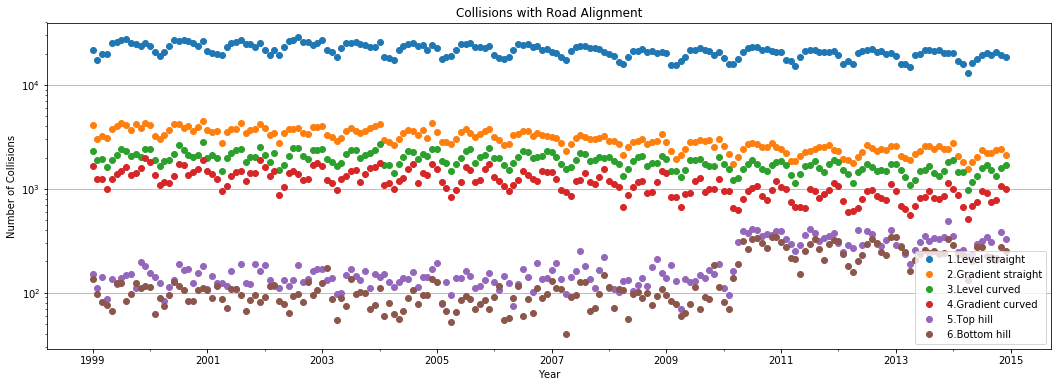

In [25]:
#Plot the dataframe into graph to visualize the result.
c_raln=['1.Level straight','2.Gradient straight',
        '3.Level curved','4.Gradient curved',
        '5.Top hill','6.Bottom hill',
        'Q.Other','U.Unknown']

df2.iloc[:,:-2].plot(logy=True, style = 'o', figsize = (18,6),
                     title = 'Collisions with Road Alignment')
plt.legend(c_raln)
plt.xlabel('Year')
plt.ylabel('Number of Collisions')
plt.grid(axis='y');


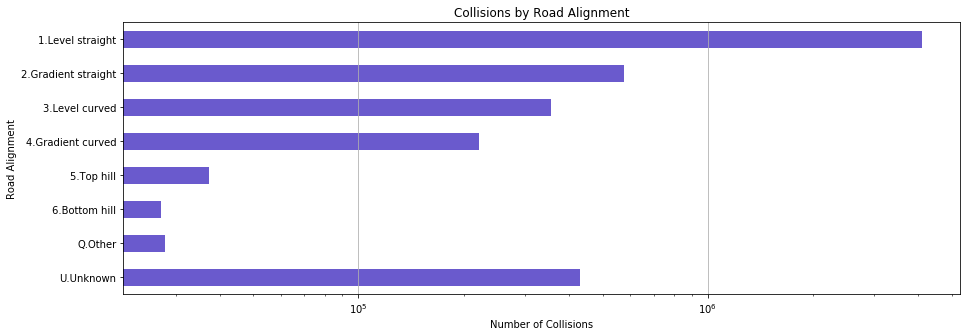

In [26]:
df3=df1.groupby('c_raln').size().sort_index(ascending=False)

df3.plot.barh(logx=True,color='slateblue',figsize=(15,5),
              title='Collisions by Road Alignment')
plt.xlabel('Number of Collisions')
plt.yticks(np.arange(0,8),c_raln[::-1])
plt.ylabel('Road Alignment')
plt.grid(axis='x');


#### Conclusion:
Most collisions happened on level and straight road, reason could be the vehicle of high speed, and driver not paying enough attention given the good road condition.  Also noted clear seasonal pattern, see the auto-correlation analysis for seasonal patterns.

### 4.2) Road Alignment & Collision Severity


In [27]:
#Use a new dataframe to analyze the relationship between Severity and Road Alignment.
#For c_sev, 1 is fatal, and 2 is non-fatal.

df1 = df_a.loc[:,['c_raln','c_sev']]
df4 = df1.groupby(['c_raln','c_sev']).size().unstack()

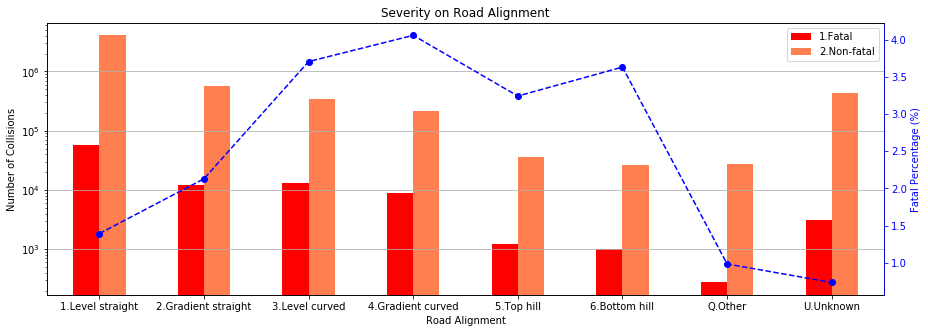

In [28]:
#Plot the relationship between Severity and Road Alignment.

#Create a twin y-axis plot area, and define axis parameters.
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

#Plot the new dataframe in logarithm, since the gap between numbers are huge.
df4.plot(kind='bar',rot=0,logy=True,color=['red','coral'],figsize=(15,5),
         title='Severity on Road Alignment', ax=ax1)
ax1.set_ylabel('Number of Collisions')
ax1.set_xlabel('Road Alignment')
ax1.grid(axis='y')
ax1.legend(['1.Fatal','2.Non-fatal'])

#Calculate the percentage of fatal injury in all accidents by
# different road alignment, and plot to right axis.
se1 = df4[1]/(df4[1]+df4[2])*100
se1.plot(c='b', style='o--', ax=ax2)
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

plt.xticks(np.arange(0,8),c_raln);


#### Conclusion:
Fatal injury represent a very small portion of all accident (less than 4% in any given cases).  It's also obvious that the level-straight road has less fatal injury, though the total number is much more than other cases; instead, the uneven condition (straight and curved) may produce severe accident.  This could be caused by limited sight.

### 4.3) Road Alignment & Number of Vehicles Involved in Collision


In [29]:
df1 = df_a.loc[:,['c_raln','c_vehs']]
df1.c_vehs.replace('UU',np.nan, inplace=True)
df1.dropna(inplace=True)
df1.c_vehs=df1.c_vehs.astype(int)
df1.c_vehs.value_counts().sort_index()

#Calculate accident portion of each event, considering 58 records that have 57 vehicle involved,
# that should be just one accident, every relevant record should be only about 1/57.
df1['acc']= 1/df1.c_vehs

#Categorize number of involved vehicles into bins.
bins = [0,5,10,20,40,60]
df1['cats'] = pd.cut(df1.c_vehs,bins)

#Summarize the collisions on road alignment and number of involved vehicles.
df5 = df1.groupby(['cats','c_raln'])['acc'].sum().unstack()
df5.dropna(how='all', inplace=True)
df5.fillna(0, inplace=True)
df5

c_raln,1,2,3,4,5,6,Q,U
cats,,,,,,,,
"(0, 5]",2.287831e+06,324641.150000,254893.316667,158273.766667,23375.216667,17733.616667,17535.366667,233456.566667
"(5, 10]",2.562835e+03,690.660317,166.184921,143.411111,55.061508,20.053571,24.761905,181.832540
"(10, 20]",1.868001e+02,35.677092,11.163280,30.610907,6.319430,1.200000,3.579983,15.766346
"(20, 40]",4.285347e+01,7.202378,1.111111,3.434295,1.409091,0.000000,0.000000,0.000000
"(40, 60]",4.201603e+00,3.544055,1.568627,0.000000,0.000000,2.819865,0.000000,0.000000


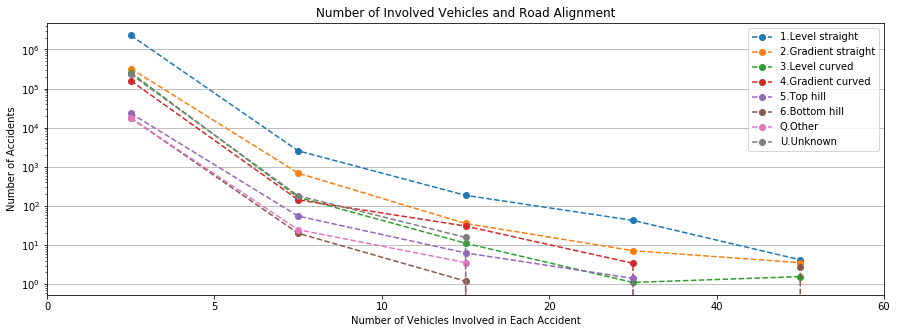

In [30]:
#Plot the result.

df5.plot(logy=True,figsize=(15,5),style='o--',
         title='Number of Involved Vehicles and Road Alignment')
plt.xticks(np.arange(-0.5,5.5),bins)
plt.xlabel('Number of Vehicles Involved in Each Accident')
plt.ylabel('Number of Accidents')
plt.legend(c_raln)
plt.grid(axis='y');

#### Conclusion:
Majority accident are involving less than 5 cars.  As the plots are very similar for different road alignments, no specific relationship observed between the two variables.

### 4.4) Road Alignment & Collision Configuration

In [31]:
#Prepare the dataset for analyse, replace non-numeric value into number to use in scatter plot.
df1 = df_a.loc[:,['c_raln','c_conf']]
df1.c_raln = df1.c_raln.replace({'Q':7,'U':8}).astype(int)
df1.c_conf = df1.c_conf.replace({'QQ':42,'UU':43,'XX':43}).astype(int)

In [32]:
#Too many collision configuration involved, iterate a list of dateframes to
# separate different collision config.
df6 = []
df6.append( df1[df1.c_conf < 10] )
df6.append( df1[(df1.c_conf > 20)&(df1.c_conf < 30)] )
df6.append( df1[(df1.c_conf > 30)&(df1.c_conf < 40)] )
df6.append( df1[df1.c_conf > 40] )


In [33]:
#Reformat the dataframe, to summarize the collision numbers in different situation,
# and store in another list of dataframe 'df7'

se6 = []; df7 = []
for i in range(0,4):
    se6.append( df6[i].groupby(['c_raln','c_conf']).size() )
    se6[i].name = 'collision'
    df7.append( pd.DataFrame(se6[i]).reset_index() )

df7[3]

,c_raln,c_conf,collision
0,1,41,60847
1,1,42,189970
2,1,43,117354
...,...,...,...
21,8,41,3618
22,8,42,8018
23,8,43,24382


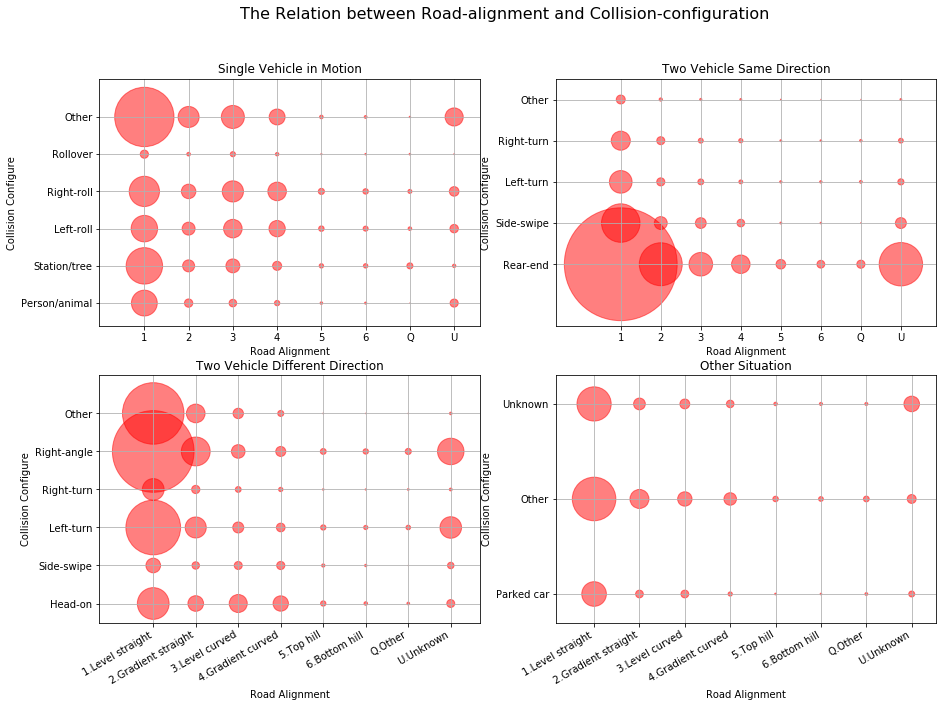

In [34]:
#Draw four subplots to show the relation between the road alignment
# and different collision situations.

fig = plt.figure(figsize=(15, 10))
fig.suptitle("The Relation between Road-alignment and Collision-configuration",
             fontsize = 16)

#---------------------- Only one car involved in collision. ---------------------- 
ax1 = fig.add_subplot(2,2,1)
ax1.set_xticks(range(1,9))
ax1.set_xticklabels([1,2,3,4,5,6,'Q','U'])
ax1.set_xlabel("Road Alignment")

ax1.set_yticks(range(1,7))
ax1.set_yticklabels(['Person/animal','Station/tree','Left-roll',
                     'Right-roll','Rollover','Other'])
ax1.set_ylabel("Collision Configure")

ax1.set_title("Single Vehicle in Motion")
ax1.scatter(df7[0].c_raln,df7[0].c_conf,
            df7[0].collision*.01,
            alpha=0.5,color='r')
plt.grid(which='major')

#---------------------- Two car same direction. ---------------------- 
ax2 = fig.add_subplot(2,2,2)
ax2.set_xticks(range(1,9))
ax2.set_xticklabels([1,2,3,4,5,6,'Q','U'])
ax2.set_xlabel("Road Alignment")


ax2.set_ylim([19.5,25.5])
ax2.set_yticks(range(21,26))
ax2.set_yticklabels(['Rear-end','Side-swipe','Left-turn','Right-turn','Other'])
ax2.set_ylabel("Collision Configure")

ax2.set_title("Two Vehicle Same Direction")
ax2.scatter(df7[1].c_raln,df7[1].c_conf,
            df7[1].collision*.01,
            alpha=0.5,color='r')
plt.grid(which='major')

#---------------------- Two car different direction. ---------------------- 
ax3 = fig.add_subplot(2,2,3)
ax3.set_xticks(range(1,9))
ax3.set_xticklabels(c_raln,rotation=30,ha='right')
ax3.set_xlabel("Road Alignment")

ax3.set_ylim([30.5,37])
ax3.set_yticks(range(31,37))
ax3.set_yticklabels(['Head-on','Side-swipe','Left-turn','Right-turn',
                     'Right-angle','Other'])
ax3.set_ylabel("Collision Configure")

ax3.set_title("Two Vehicle Different Direction")
ax3.scatter(df7[2].c_raln,df7[2].c_conf,
            df7[2].collision*.01,
            alpha=0.5,color='r')
plt.grid(which='major')

#---------------------- Other situation. ---------------------- 
ax4 = fig.add_subplot(2,2,4)
ax4.set_xticks(range(1,9))
ax4.set_xticklabels(c_raln,rotation=30,ha='right')
ax4.set_xlabel("Road Alignment")

ax4.set_ylim([40.7,43.3])
ax4.set_yticks(range(41,44))
ax4.set_yticklabels(['Parked car','Other','Unknown'])
ax4.set_ylabel("Collision Configure")

ax4.set_title("Other Situation")
ax4.scatter(df7[3].c_raln,df7[3].c_conf,
            df7[3].collision*.01,
            alpha=0.5,color='r')
plt.grid(which='major');

#### Conclusion:
The size of each dot indicate the collision numbers in each setting, same scale factor used for all subplots, which makes the number in each plot comparable to its neighbour.  In all cases, clear trend shows that the collision chance increases when road-alignment getting better, due to higher speed and less caution.  Except the unknown or "other" conditions, we can see in each cases:
1. most collision for one car accident is hitting a static object, followed closely by right and left roll on to shoulder.
2. for two car in same direction, most accidents are rear-end collision, which clearly increase along road-alignment.
3. for two car in different direction, right-angle collision is huge, guess is in intersection.  Left turn also post a lot risk, but right-turn is very low, even lower than head-on collision.  This may be a result of the inherent complexity of left turn.

### Conclusion from Road Alignment analysis:
From all test performed above, we have following observations:
1. Most collisions happened in level and aligned road.  Drivers should pay more attention when drive on good road condition, and follow speed limit.
2. However, bad road alignment may post higher risk of fatal accident.  Drivers need to anticipate possible outcome when the view is not so wide, and always be cautious to avoid serious injury as possible.
3. Rear-end collision is the most popular collision type.  Keep enough space to the car in front of you, especially on well aligned road.
4. Right-angle collision and left-turn collision are also popular, wait one more second before turning your wheel, or rushing into the intersection.

---
### 5 Vehicle Type
### 5.1) Vehicle Type & Time Relation

In [35]:
df1 = df_a.loc[:,['c_mnth','v_type']]

#Aggregate the events by month into a summarized dataframe.
df2 = df1.groupby(['c_mnth','v_type']).size().unstack()
df2.index = df2.index.astype(int)
df2.fillna(0, inplace=True)

v_type = ['1.Light Duty', '5.Cargo <4.5t', '6.Truck <4.5t',
          '7.Truck >4.5t', '8.Road tractor', '9.School bus',
          '10.Small school bus', '11.Urban bus', '14.Motorcycle',
          '16.Off-road', '17.Bicycle', '18.Motorhome', '19.Farm equip.',
          '20.Constru. equip.', '21.Fire engine', '22.Snowmobile',
          '23.Street car', 'N.Not vehicle', 'Q.Others', 'U.Unknown']
months = ['Jan','Feb','Mar','Apr','May','Jun',
          'Jul','Aug','Sep','Oct','Nov','Dec']

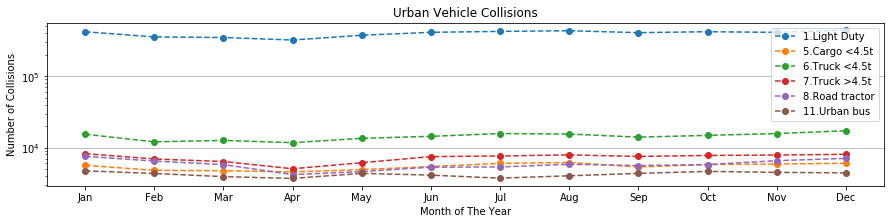

In [36]:
df2.iloc[:,[0,1,2,3,4,7]].plot(logy=True, figsize = (15,3), style = 'o--',
                               title = 'Urban Vehicle Collisions')
plt.legend(v_type[0:5]+[v_type[7]])
plt.xticks(range(1,13),months)
plt.xlabel('Month of The Year')
plt.ylabel('Number of Collisions')
plt.grid(axis='y');

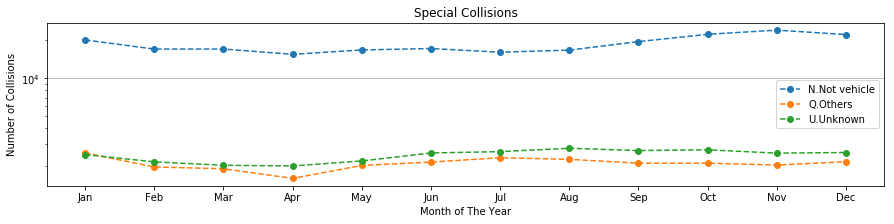

In [37]:
df2.iloc[:,17:20].plot(logy=True, figsize = (15,3), style = 'o--',
                       title = 'Special Collisions')
plt.legend(v_type[17:20])
plt.xticks(range(1,13),months)
plt.xlabel('Month of The Year')
plt.ylabel('Number of Collisions')
plt.grid(axis='y');

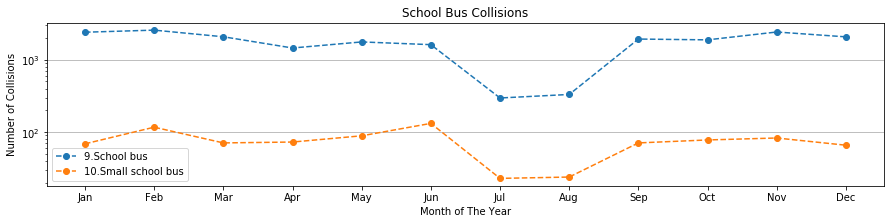

In [38]:
df2.iloc[:,5:7].plot(logy=True, figsize = (15,3), style = 'o--',
                     title = 'School Bus Collisions')
plt.legend(v_type[5:7])
plt.xticks(range(1,13),months)
plt.xlabel('Month of The Year')
plt.ylabel('Number of Collisions')
plt.grid(axis='y');

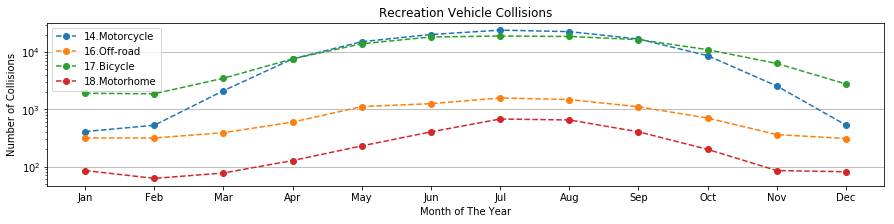

In [39]:
df2.iloc[:,8:12].plot(logy=True, figsize = (15,3), style = 'o--',
                      title = 'Recreation Vehicle Collisions')
plt.legend(v_type[8:12])
plt.xticks(range(1,13),months)
plt.xlabel('Month of The Year')
plt.ylabel('Number of Collisions')
plt.grid(axis='y');

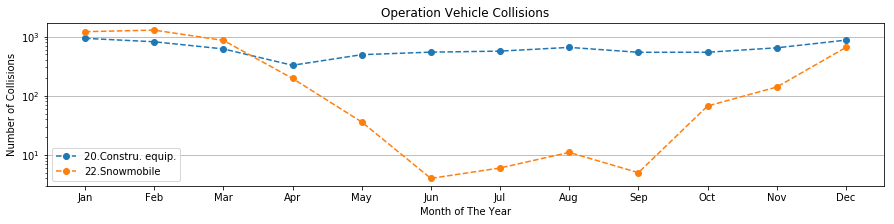

In [40]:
df2.iloc[:,[13,15]].plot(logy=True, figsize = (15,3), style = 'o--',
                         title = 'Operation Vehicle Collisions')
plt.legend([v_type[13],v_type[15]])
plt.xticks(range(1,13),months)
plt.xlabel('Month of The Year')
plt.ylabel('Number of Collisions')
plt.grid(axis='y');

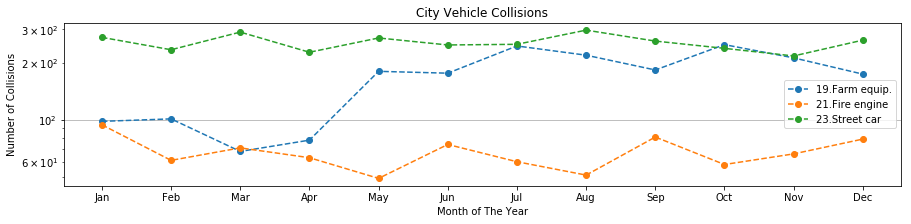

In [41]:
df2.iloc[:,[12,14,16]].plot(logy=True, figsize = (15,3), style = 'o--',
                            title = 'City Vehicle Collisions')
plt.legend([v_type[12],v_type[14],v_type[16]])
plt.xticks(range(1,13),months)
plt.xlabel('Month of The Year')
plt.ylabel('Number of Collisions')
plt.grid(axis='y');

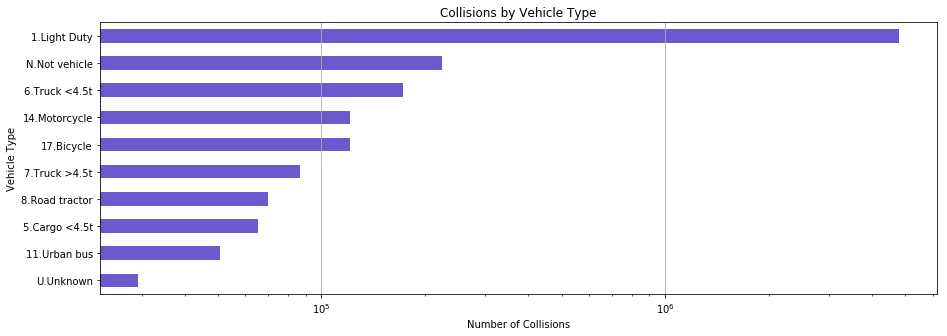

In [42]:
#Plot the total collisions by different vehicle types (top 10):

df3 = pd.DataFrame(df1.groupby('v_type').size().sort_index())
df3['types'] = v_type
df3 = df3.rename(columns={0:'collisions'}).set_index('types').sort_values(by='collisions')

df3[-10:].plot.barh(logx=True,color='slateblue',figsize=(15,5),
                    title='Collisions by Vehicle Type',legend=None)
plt.xlabel('Number of Collisions')
plt.ylabel('Vehicle Type')
plt.grid(axis='x');

#### Conclusion:
By looking at the plots above, clear pattern shown in different vehicle types:
1. Vast majority collisions are caused by light duty vehicles, followed by light truck, motorcycle and bicycle.  This is due to the dominant population of the personal vehicles, and the unprofessional nature of the drivers.
2. The collisions distribution for urban vehicles (light duty, trucks, road tractor, and bus) is flat across all seasons, without showing obvious pattern, indicating urban traffic being busy for all time.
3. School bus involved collisions happened much less in July and August, due to summer vacation.
4. More accident related to bicycle, motorcycle, off-road vehicle and motorhome happened from April to October, as they are used for outdoor activities during summer time; in opposite, snow-mobile collisions are more from October to April.

### 5.2) Vehicle Type & Severity

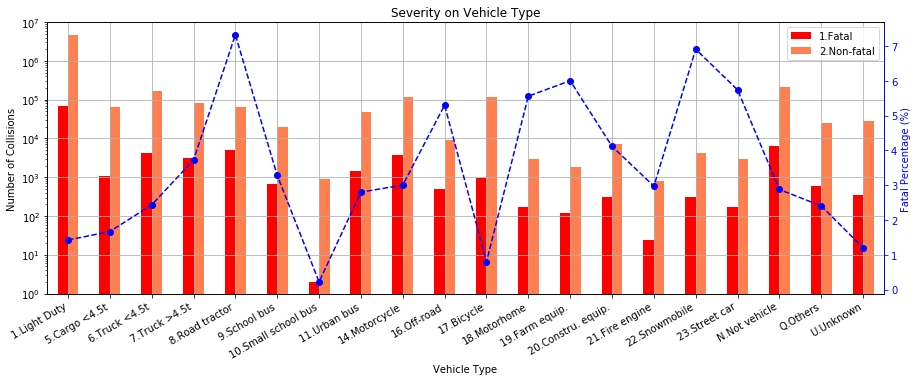

In [43]:
#Use a new dataframe to analyze the relationship between Severity and Road Alignment.
#For c_sev, 1 is fatal, and 2 is non-fatal.

df1 = df_a.loc[:,['v_type','c_sev']]
df4 = df1.groupby(['v_type','c_sev']).size().unstack().fillna(0)

#Plot the relationship between Severity and Vehicle Type.

#Create a twin y-axis plot area, and define axis parameters.
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

#Plot the new dataframe in logarithm, since the gap between numbers are huge.
df4.plot(kind='bar',rot=30,logy=True,color=['red','coral'],figsize=(15,5),
         title='Severity on Vehicle Type', ax=ax1)
ax1.set_xticklabels(v_type,ha='right')
ax1.set_xlabel('Vehicle Type')
ax1.set_ylabel('Number of Collisions')
ax1.grid(axis='both')
ax1.legend(['1.Fatal','2.Non-fatal'])

#Calculate the percentage of fatal injury in all accidents by different road alignment,
# and plot to right axis.
se1 = df4[1]/(df4[1]+df4[2])*100
se1.plot(c='b', style='o--', ax=ax2)
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

plt.xticks(np.arange(0,20),v_type);


#### Conclusion:
From the figure above we see most fatal collisions are caused by light-duty vehicles, followed by motorcycle, road tractor, and trucks.  However, the highest percentage of fatal accidents is caused by road tractor and Snowmobile (about 7%), and followed by street car, farm equipment and motorhome (around 6%).
Also noticed that small school bus produces least fatal collisions, and bicycle number is also non-surprisingly low.


### Conclusion from Vehicle Type analysis:
Clear seasonal patterns observed for certain types:
- School bus involved in collisions out of summer vacation (July and August);
- Vehicles for out-door activities (i.e., bicycle, motorcycle, off-road vehicle and motorhome) involved in collisions mostly during summer time (April to October);
- In opposite, snow-mobile collisions are more from October to April.

While light duty vehicles, light trucks, motorcycles and bicycles involved in most of the collisions, most fatal collision ratio observed from following types:
- Road tractor and Snowmobile is around 7%;
- Street car, farm equipment and motorhome is about 6%.

If you see those vehicle when you drive, try stay away from them.

---
### 6. Vehicle Model Year
### 6.1) Vehicle Model Year & Time Relation

In [44]:
#Prepare the dataset and clean it.
df1 = df_a.loc[:,['c_year','v_year']]

df1.v_year.replace({'NNNN':NA,'UUUU':NA,'XXXX':NA},inplace=True)
df1.dropna(inplace=True)
df1 = df1.astype(int)

#Aggregate the collisions by year into a summarized dataframe (model year as index).
df2 = df1.groupby(['v_year','c_year']).size().unstack()
df2.fillna(0, inplace=True)
df2 = df2.astype(int)
df2

c_year,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
v_year,,,,,,,,,,,,,,,,
1901,10,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0
1903,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1904,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,0,0,0,0,0,0,0,0,0,0,0,0,0,1497,14284,19093
2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1362,12926
2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1223


In [45]:
#Number of collisions grouped by vehicle model year range (12 ranges as columns)
bins = list(range(1900,2021,10))
df2['cats'] = pd.cut(df2.index,bins,labels=bins[:-1])
df3 = df2.groupby('cats').sum().T
df3

cats,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010
c_year,,,,,,,,,,,,
1999,31,16,13,24,33,108,825,8669,140947,216958,0,0
2000,0,29,20,79,27,91,635,7013,125229,241490,2221,0
2001,2,16,28,49,29,66,535,5574,102097,233222,24967,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2012,0,3,8,7,5,20,129,509,3969,57286,194283,31792
2013,0,5,11,5,11,24,123,385,3088,44588,184030,51811
2014,0,17,6,3,6,24,88,346,2487,34301,162115,66719


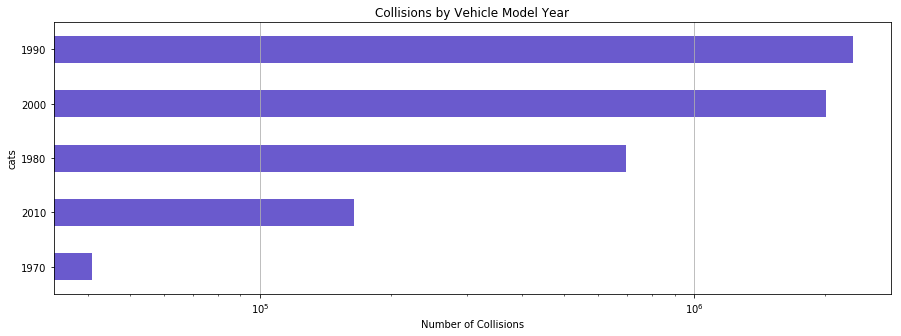

In [46]:
#Plot result of most involved model years:
se4=df3.sum().sort_values()
se4[-5:].plot.barh(logx=True,color='slateblue',figsize=(15,5),
                   title='Collisions by Vehicle Model Year')
plt.xlabel('Number of Collisions')
plt.grid(axis='x');

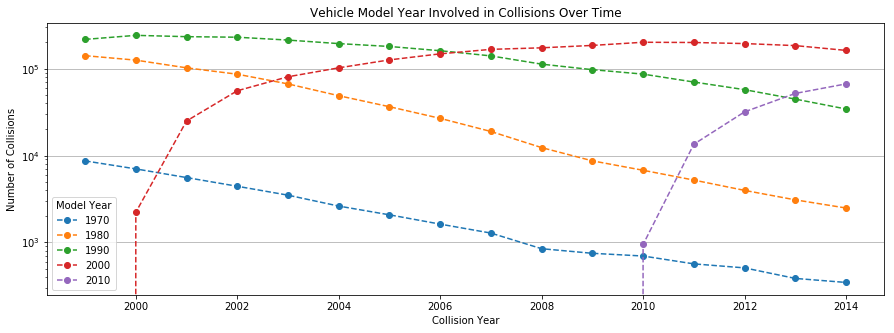

In [47]:
#Plot the trending of model year involved in collision.
df3.iloc[:,7:].plot(logy=True,style='o--',figsize=(15,5),
                    title='Vehicle Model Year Involved in Collisions Over Time')
plt.xlabel('Collision Year')
plt.ylabel('Number of Collisions')
plt.legend(title='Model Year')
plt.grid(axis='y');

### Conclusion from Vehicle Model Year analysis:
As the data covers collisions from 1999 to 2014, most cars involved in collisions are made in recent thirty years.
Clear trend observed that the model getting involved in collision peaks in its 10 years' age, which could be a result of the market share growth and the reliability drops for old vehicles.

---
### 7. Person Sex
### 7.1) Sex & Collision Hour

In [48]:
#Generating working data set 'df_d' by keeping the using elements
df_d = df.loc[:,['c_hour','c_vehs','c_wday',
                 'c_conf','p_sex','p_age','p_isev','p_user']]
df_d

,c_hour,c_vehs,c_wday,c_conf,p_sex,p_age,p_isev,p_user
0,20,02,1,34,M,41,1,1
1,20,02,1,34,M,19,1,1
2,20,02,1,34,F,20,2,2
...,...,...,...,...,...,...,...,...
5860378,19,01,7,03,F,35,2,1
5860379,19,01,7,03,M,26,1,2
5860380,19,01,7,03,F,15,2,2


In [60]:
# define 0 as men; 1 as women
df_d.p_sex.replace({'M':0,'F':1},inplace=True)
# Clean the missing variable by droping the row which contains any missing variables
df_d.replace('[^0-9]+',np.nan,regex=True,inplace=True)
df_d.dropna(inplace=True)

In [61]:
num = df_d.groupby(['p_sex']).count()
print(num)

        c_hour   c_vehs   c_wday   c_conf    p_age   p_isev   p_user
p_sex                                                               
0.0    2608529  2608529  2608529  2608529  2608529  2608529  2608529
1.0    2116502  2116502  2116502  2116502  2116502  2116502  2116502


In [62]:
df1 = df_d.loc[:,['p_sex','c_hour']].groupby(['c_hour','p_sex']).size().unstack()
df1

p_sex,0.0,1.0
c_hour,,
00,45496,24789
01,39313,19083
02,42667,18743
...,...,...
21,94452,70296
22,79072,54108
23,63351,39055


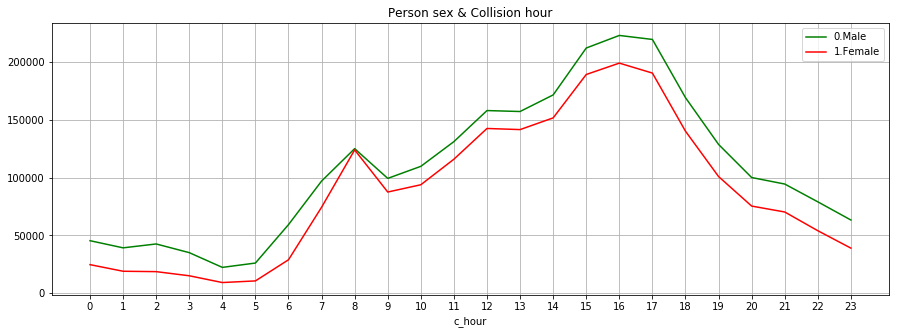

In [63]:
df1.plot(rot=0,color=['g','r'],figsize=(15,5),
         title='Person sex & Collision hour')
plt.legend(['0.Male','1.Female'])
plt.xticks(range(0,24),range(0,24))
plt.grid();

In [64]:
#8 o'clock:
df1.iloc[8,]

p_sex
0.0    125047
1.0    123961
Name: 08, dtype: int64

#### Conclusion: 
Man is more likely to involve in a collision accident at all times. However, the collision times of male and female are very close to each other at 8 am, around 125,047 and 123,961.   

Also, for both male and female, the riskiest time period is from 3 pm to 5 pm, and then the risk has a monotonically decreasing trend.

### 7.2) Sex & Medical Treatment Required

In [65]:
df2 = df_d.loc[:,['p_sex','p_isev']].groupby(['p_sex','p_isev']).size().unstack()
df2

p_isev,1,2,3
p_sex,,,
0.0,1275004,1308971,24554
1.0,733657,1371725,11120


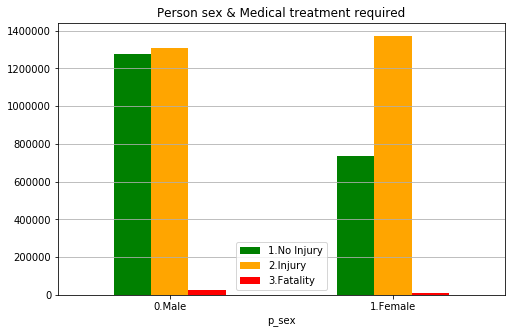

In [66]:
df2.plot(kind='bar',rot=0, color=['g','orange','r'], figsize=(8,5),
         title='Person sex & Medical treatment required')
plt.legend(['1.No Injury','2.Injury','3.Fatality'])
plt.xticks(range(0,2),['0.Male','1.Female'])
plt.grid(axis='y');

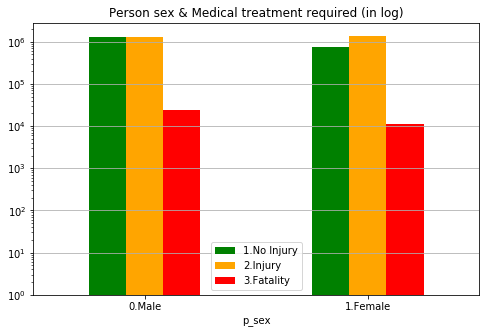

In [67]:
#Same result in logarithm scale.
df2.plot(kind='bar',rot=0, color=['g','orange','r'], figsize=(8,5),log= True,
         title='Person sex & Medical treatment required (in log)')
plt.legend(['1.No Injury','2.Injury','3.Fatality'])
plt.xticks(range(0,2),['0.Male','1.Female'])
plt.grid(axis='y');

#### Conclusion:
Female are more likely to injure in an accident, compared to male. However, men are twice as likely as women to die in an accident.

### 7.3) Sex & Collision Configuration

In [68]:
#Prepare sub-dataset
df3 = df_d.loc[:,['p_sex','c_conf']].groupby(['c_conf','p_sex']).size().unstack()
df3

p_sex,0.0,1.0
c_conf,,
01,41645,31311
02,81487,64589
03,90563,59520
...,...,...
35,407601,346762
36,217676,183779
41,25521,17613


In [69]:
#Prepare labels for x-axis
x_label=['01.SV Hit movible','02.SV Hit stationary','03.SV Ran off left shoulder',
         '04.SV Ran off right shoulder','05.SV Rollover on roadway',
         '06.SV Others','21.2V SD Rear','22.2V SD side-swipe',
         '23.2V SD Lf','24.2V SD Rt','25.2V Others','31.2V DD Head',
         '32.2V DD side-swipe','33.2V DD Lf','34.2V DD Rt','35.2V DD Right angle',
         '36.2V DD other','41.Hit parked vehicle']
len(x_label)

18

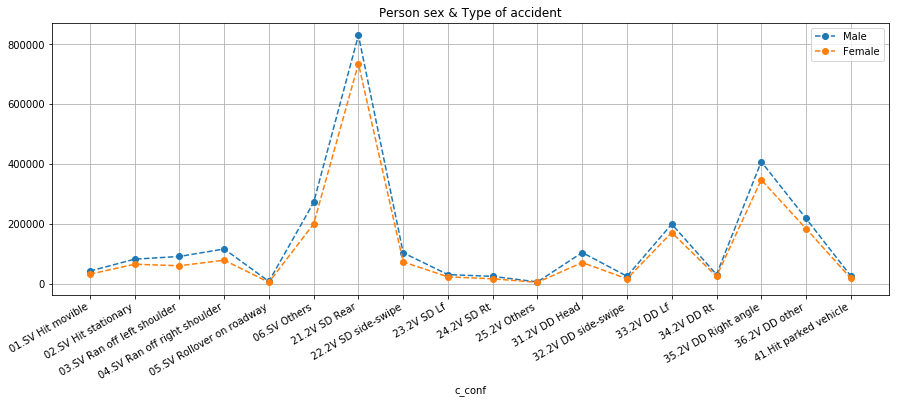

In [70]:
df3.plot(style = 'o--', figsize = (15,5),
         title='Person sex & Type of accident')
plt.legend(['Male','Female'])
plt.xticks(range(0,18),x_label,rotation=30,ha='right');
plt.grid();

#### Conclusion:
for all kinds of collision configurations, the male has higher collision risk. The rear-end collision is the most frequent type of the traffic accidents for both man and woman. Also, the second main type is right-angle side collision. Additionally, Rollover on a roadway is the least common type of accident.

---
### 8. Person Age
### 8.1) Person Age & Collision Hour

In [71]:
#Prepare sub-dataset, manage NA value
df4 = df_d.loc[:,['p_age','c_hour']].astype(int).groupby(['p_age','c_hour']).size().unstack()
df4.fillna(0, inplace=True)

In [72]:
#Bin ages into 10 buckets.
bins = list(range(0,101,10))
df4['age'] = pd.cut(df4.index,bins,labels=bins[:-1])
df5 = df4.groupby('age').sum()
df5 = df5.T
df5

age,0,10,20,30,40,50,60,70,80,90
c_hour,,,,,,,,,,
0,1217.0,20387.0,21615.0,11212.0,8613.0,4736.0,1711.0,625.0,157.0,12.0
1,763.0,17252.0,19608.0,9088.0,6413.0,3438.0,1281.0,443.0,102.0,8.0
2,545.0,17969.0,23646.0,9245.0,5679.0,2857.0,1018.0,342.0,100.0,9.0
...,...,...,...,...,...,...,...,...,...,...
21,6302.0,42388.0,40481.0,25686.0,23317.0,14988.0,7099.0,3445.0,959.0,83.0
22,3724.0,35288.0,35680.0,21055.0,18050.0,11177.0,5189.0,2327.0,651.0,39.0
23,2082.0,28809.0,29501.0,16461.0,13096.0,7784.0,3153.0,1196.0,302.0,22.0


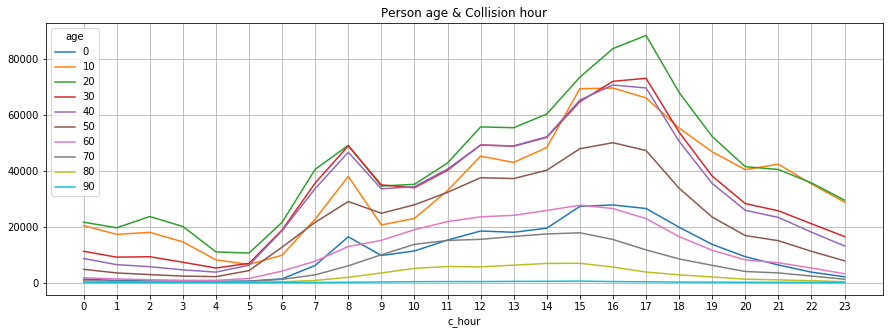

In [73]:
df5.plot(rot=0,figsize=(15,5), title='Person age & Collision hour')
#plt.legend(['0.Male','1.Female'])
plt.xticks(range(0,24),range(0,24))
plt.grid();

#### Conlcusion:
The most dangerous population is from 21 to 30 years old.   
Also, the youth whose age is from 11 to 20 are more likely to involve in a collision at night, especially from 9 pm to 1 am.  
At morning (8 am to 11 am), three age-groups (21 to 30; 31 to 40; 41 to 50) has the similar number of accident.  
In the end, the graph shows the working people share the same pattern, which is the rush hour is likely to collide.  

### 8.2) Age & Day of Week

In [74]:
df6 = df_d.loc[:,['p_age','c_wday']].astype(int).groupby(['c_wday','p_age']).size().unstack().T
df6

c_wday,1,2,3,4,5,6,7
p_age,,,,,,,
1,4713,4936,5049,5159,6147,5712,4861
2,3052,3103,3156,3332,3853,3836,3129
3,3055,3237,3204,3270,3833,3826,3221
...,...,...,...,...,...,...,...
97,13,19,11,16,12,17,10
98,22,13,19,23,34,21,19
99,27,22,21,43,39,39,29


In [75]:
bins = list(range(0,101,10))
df6['age'] = pd.cut(df6.index,bins,labels=bins[:-1])
df7 = df6.groupby('age').sum()
df7 = df7.T
df7

age,0,10,20,30,40,50,60,70,80,90
c_wday,,,,,,,,,,
1,32375,102785,131201,109193,104862,74305,39475,23260,8091,526
2,32874,104719,136343,115386,111810,78813,43216,25414,9196,581
3,32814,105537,137327,116985,112477,79492,43020,25553,9108,597
...,...,...,...,...,...,...,...,...,...,...
5,42190,143611,172535,137507,130276,91212,48919,28533,9872,652
6,44406,137920,159724,113640,104912,72032,38817,22539,7873,540
7,36962,113985,132344,90299,83311,57634,31186,18735,6883,475


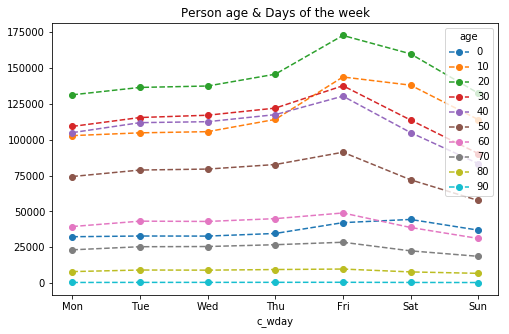

In [76]:
df7.plot(rot=0,figsize=(8,5),title='Person age & Days of the week',style='o--')
plt.xticks(range(1,8),['Mon','Tue','Wed','Thu','Fri','Sat','Sun']);
#plt.grid(axis='y');

#### Conlusion:
During the whole week, young adults (from 21 to 31) are risky population.The risk decrease with age increases, for example, the age from 41 to 50 are less likely to involve in an accident, compared with whose age is from 31 to 40. Also, the collision probabilities of the youth significantly increased over the weekend.

### 8.3) Age & Medical Treatment Required

In [77]:
df8 = df_d.loc[:,['p_age','p_isev']].astype(int).groupby(['p_age','p_isev']).size().unstack()
df8.fillna(0, inplace=True)
df8

p_isev,1,2,3
p_age,,,
1,25964,10486,127
2,16527,6870,64
3,15825,7763,58
...,...,...,...
97,30,65,3
98,45,103,3
99,103,112,5


In [78]:
bins = list(range(0,101,10))
df8['age'] = pd.cut(df8.index,bins,labels=bins[:-1])
df9 = df8.groupby('age').sum()
df9 

p_isev,1,2,3
age,,,
0,152003,103456,815
10,339240,477657,5726
20,411785,596179,7064
...,...,...,...
70,68856,99135,2856
80,22480,36303,1764
90,1343,2464,184


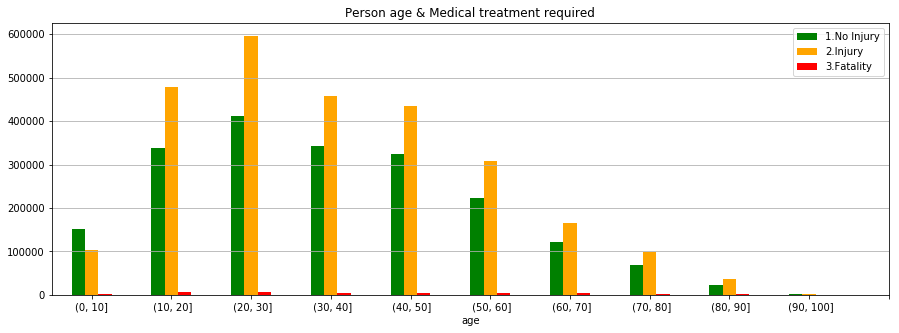

In [79]:
df9.plot(kind='bar',rot=0, color=['g','orange','r'],figsize=(15,5),
         title='Person age & Medical treatment required')
plt.legend(['1.No Injury','2.Injury','3.Fatality'])
plt.xticks(range(0,11),['(0, 10]',' (10, 20]',' (20, 30]',' (30, 40]',
                        ' (40, 50]',' (50, 60]',' (60, 70]',' (70, 80]',
                        ' (80, 90]',' (90, 100]'])
plt.grid(axis='y');

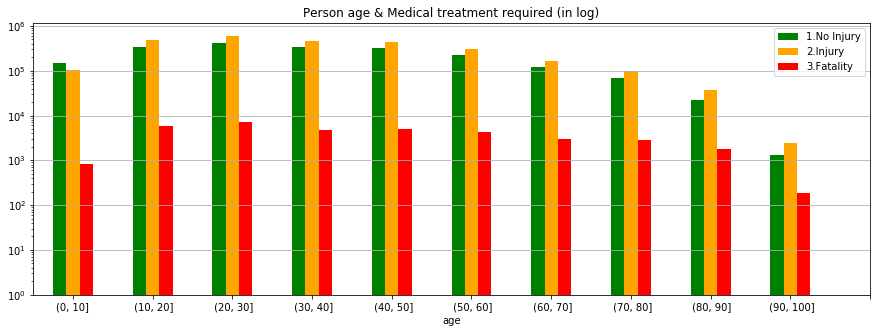

In [80]:
df9.plot(kind='bar',rot=0, color=['g','orange','r'],figsize=(15,5),log= True,
         title='Person age & Medical treatment required (in log)')
plt.legend(['1.No Injury','2.Injury','3.Fatality'])
plt.xticks(range(0,11),['(0, 10]',' (10, 20]',' (20, 30]',' (30, 40]',
                        ' (40, 50]',' (50, 60]',' (60, 70]',' (70, 80]',
                        ' (80, 90]',' (90, 100]'])
plt.grid(axis='y');

In [81]:
#Verifying result using(20,30] age group
df_d[(df_d.p_age.astype(int)> 20) & (df_d.p_age.astype(int)<= 30)].p_isev.value_counts()

2    596179
1    411785
3      7064
Name: p_isev, dtype: int64

In [82]:
#Verifying result using (50,60] age group
df_d[(df_d.p_age.astype(int)> 50) & (df_d.p_age.astype(int)<= 60)].p_isev.value_counts()

2    308020
1    223739
3      4381
Name: p_isev, dtype: int64

#### Conlusion:
Except for whose age below 10, other age groups show the similar conclusion that people are more likely to injure in a collision.  
Same as before, the graph shows the youth are the most dangerous group because they have the highest probability to involve in a collision regardless of the severity (not injure, injure or die).

---
### 9. Road User Class
### 9.1) Road User Class & Medical Treatment Required

In [83]:
df10 = df_d.loc[:,['p_user','p_isev']].astype(int).groupby(['p_user','p_isev']).size().unstack()
df10.fillna(0, inplace=True)
df10

p_isev,1,2,3
p_user,,,
1,1386909,1612318,19119
2,606762,746529,8422
3,3801,167333,4645
4,2616,65644,690
5,8573,88872,2798


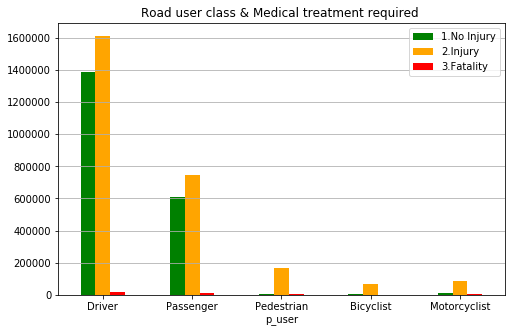

In [84]:
df10.plot(kind='bar',rot=0,color=['g','orange','r'],figsize=(8,5),
          title='Road user class & Medical treatment required ')
plt.legend(['1.No Injury','2.Injury','3.Fatality'])
plt.xticks(range(0,5),['Driver','Passenger','Pedestrian',
                       'Bicyclist', 'Motorcyclist'])
plt.grid(axis='y');

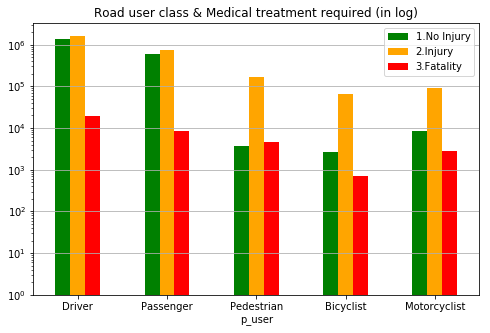

In [85]:
df10.plot(kind='bar',rot=0,color=['g','orange','r'],figsize=(8,5),
          log = True, title='Road user class & Medical treatment required (in log)')
plt.legend(['1.No Injury','2.Injury','3.Fatality'])
plt.xticks(range(0,5),['Driver','Passenger','Pedestrian',
                       'Bicyclist', 'Motorcyclist'])
plt.grid(axis='y');

#### Conclusion:
Drivers are twice likely to get hurt or die than passengers. Among all 5 categories, bicyclists are the safest.
### 9.2) Road User Class & Collision Configuration


In [86]:
df11 = df_d.loc[:,['p_user','c_conf']].groupby(['c_conf','p_user']).size().unstack()
df11.fillna(0,inplace=True)
df11

p_user,1,2,3,4,5
c_conf,,,,,
01,35686,14033,21714,118,1405
02,69756,25725,46754,164,3677
03,92565,50989,410,67,6052
...,...,...,...,...,...
35,491284,217906,5609,29961,9603
36,261185,124325,930,7453,7562
41,25943,12018,3177,765,1231


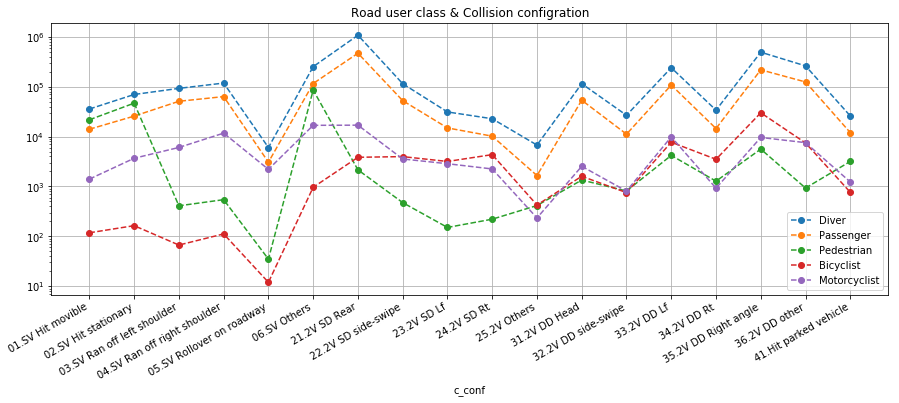

In [87]:
df11.plot(style = 'o--', logy = True, figsize = (15,5),
          title='Road user class & Collision configration' )
plt.legend(['Diver','Passenger','Pedestrian',
            'Bicyclist', 'Motorcyclist'])
plt.xticks(range(0,18),x_label,rotation=30,ha='right')
plt.grid();

#### Conclusion:
It is no surprise that driver and passenger have an identical pattern, both of them are more likely to involve in a rear-end collision, and the second common type is a right-angle collision.  
It is infrequent that a single vehicle rollover on a roadway, causing pedestrian or bicyclists to injure or die.  
However, for pedestrian, they are more likely to involve in any other single vehicle collision type; for bicyclists, they are more likely to get hurt in a right-angle collision.  
Among all types of accidents, Motorcyclists get a middling ranking.

---
### 10. Number of Vehicles Involved in Collision
### 10.1) Number of Vehicles Involved in Collision & Time Relation

In [88]:
#Prepare dataset 'df_c'
df_c = dfp.loc[:,['date','c_year','c_mnth','c_wday',
                  'c_hour','c_sev','c_vehs','c_conf','p_psn','p_safe']]
df_c[['c_sev','c_vehs','c_conf','p_psn','p_safe']] =\
        df_c[['c_sev','c_vehs','c_conf','p_psn','p_safe']].replace('^([A-Za-z])+$', np.nan, regex=True)
df_c = df_c.dropna()

#This process is to eliminate the '0' preceding a single digit number. ex. 01 --> 1, converting str objects to int
df_c[['c_vehs','c_conf','p_safe']] = df_c[['c_vehs','c_conf','p_safe']].fillna(-1).astype(int)
df_c

,date,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,p_psn,p_safe
2,1999-01,1999,01,1,20,2,2,34,13,2
10,1999-01,1999,01,1,15,2,1,4,13,2
12,1999-01,1999,01,1,14,2,2,31,11,2
...,...,...,...,...,...,...,...,...,...,...
5860378,2014-12,2014,12,7,19,2,1,3,11,2
5860379,2014-12,2014,12,7,19,2,1,3,13,2
5860380,2014-12,2014,12,7,19,2,1,3,21,2


In [89]:
#Number of vehicles invovled in collision over time
df1 = df_c.loc[:,['date','c_vehs']]

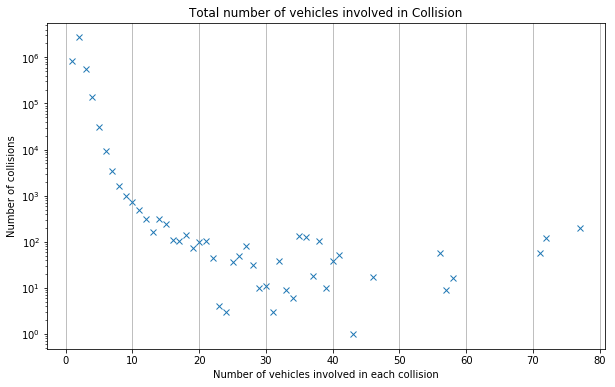

In [90]:
#Total number of vehicles involved in collision 
df2 = df1.groupby('c_vehs').size().sort_index()
df2.plot(style='x',logy=True, figsize=(10,6),
         title='Total number of vehicles involved in Collision')
plt.grid(axis='x');
plt.xlabel('Number of vehicles involved in each collision')
plt.ylabel('Number of collisions');

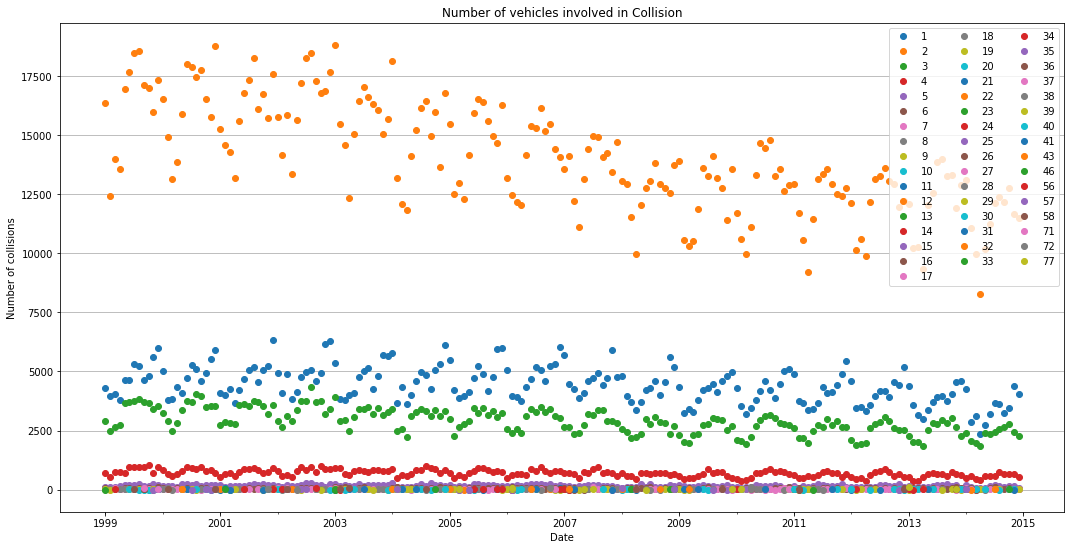

In [91]:
#Visualize the result
vehs = df1.groupby(['date','c_vehs']).size().unstack()
vehs.plot(style = 'o', figsize=(18,9),
                  title = 'Number of vehicles involved in Collision')
plt.grid(axis='y')
plt.xlabel('Date')
plt.legend(ncol=3)
plt.ylabel('Number of collisions'); 

#### Conclusion:
From the graph above, we can see that over time the most frequent number of vehicles involved in collisions is 2 vehicles.  
Since it was hard to view the results in detail, I decided to slice the data with the top 5 number of vehicles involved in collision:  
c_vehs= 1-5, to view the pattern better. 

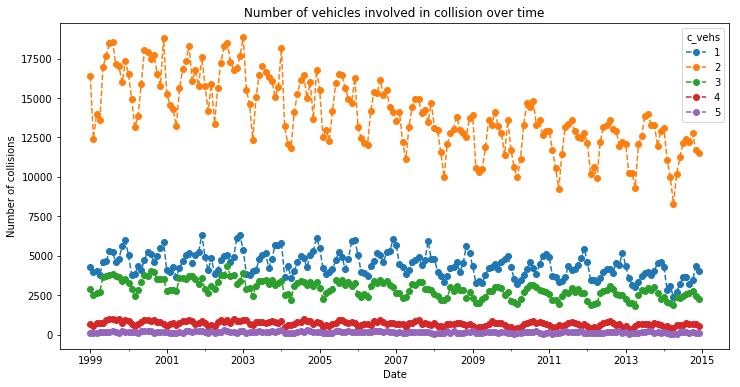

In [92]:
#Selected c_vehs 1-5 to view the top 5 most frequent number of vehicles involved in collisions 
a = vehs.iloc[:,0:5]
a.plot(style='o--',figsize=(12,6),
       title='Number of vehicles involved in collision over time')
plt.xlabel('Date')
plt.ylabel('Number of collisions');

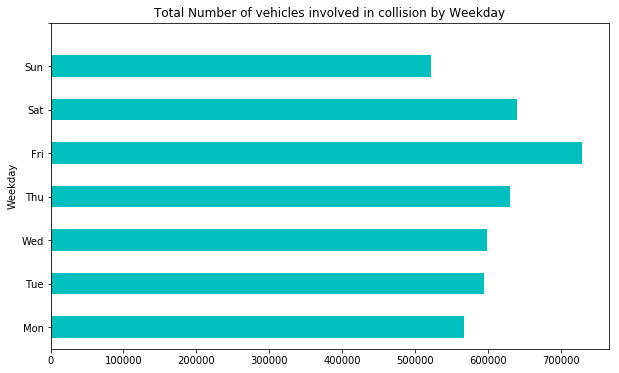

In [93]:
#Total number of vehicles involved in collision in regards to weekday
df3 = df_c.loc[:,['c_wday','c_vehs']]
weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
w_day = df3.groupby('c_wday')['c_vehs'].size()

#Visualize the result
w_day.plot(kind='barh', color='c',figsize=(10,6),rot =0,
           title='Total Number of vehicles involved in collision by Weekday')
plt.yticks(range(0,8),weekday)
plt.ylabel('Weekday');

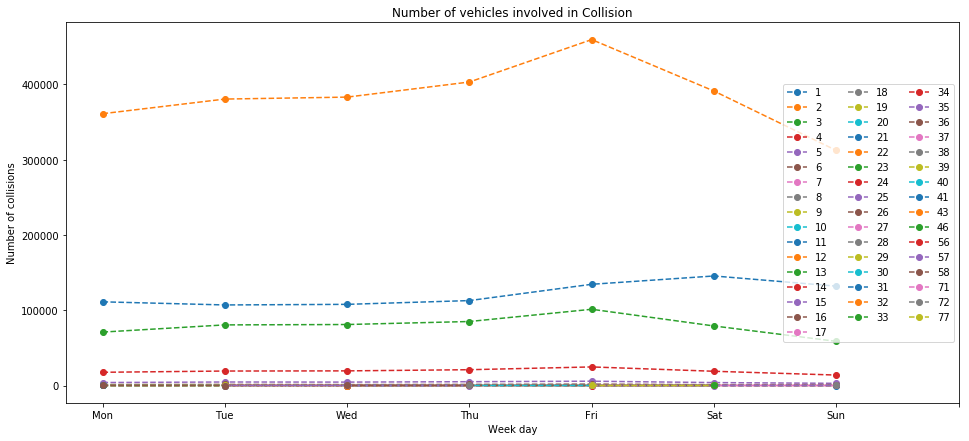

In [94]:
#Relationship of number of vehicles involved in collision (1-57 vehicles) on a specific weekday 
w_day1 = df3.groupby(['c_wday','c_vehs']).size().unstack()

w_day1.plot(style = 'o--', figsize=(16,7),
            title = 'Number of vehicles involved in Collision')
plt.legend(ncol=3,loc=7)
plt.xticks(range(0,8),weekday)
plt.xlabel('Week day')
plt.ylabel('Number of collisions');

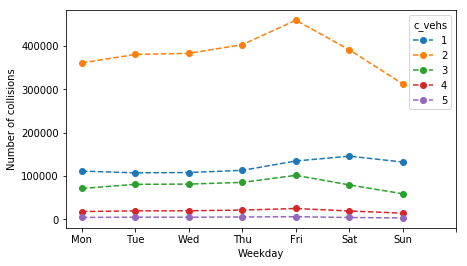

In [95]:
b = w_day1.iloc[:,0:5]
b.plot(figsize=(7,4),style='o--')
plt.xlabel('Weekday')
plt.ylabel('Number of collisions')
plt.xticks(range(0,8),weekday);

#### Conclusion:
From the graph above, we can see that the most frequent number of vehicles involved in collisions over week day was 2 vehicles followed by 1 and 3 vehicles involved in collisions.  
Over the week days, it seems that the number of collisions increase from Thursday and peak on Friday and start declining towards Sunday. 

In [96]:
#Slice the data with just Number of vehicles involved in collision & hour
df4 = df_c.loc[:,['c_hour','c_vehs']]
df4

,c_hour,c_vehs
2,20,2
10,15,1
12,14,2
...,...,...
5860378,19,1
5860379,19,1
5860380,19,1


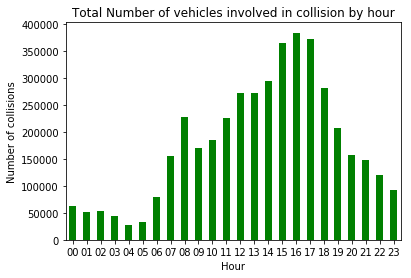

In [97]:
#Total Number of vehicles involved in collision by hour
hour = df4.groupby('c_hour')['c_vehs'].size()
hour.plot(kind='bar',color='G',rot=0,
          title='Total Number of vehicles involved in collision by hour')
plt.xlabel('Hour')
plt.ylabel('Number of collisions');

#### Conlusion:
From the graph above, it seems that most collisions happen rush hour starting 15:00 till 17:59 and 8:00-8:59. 

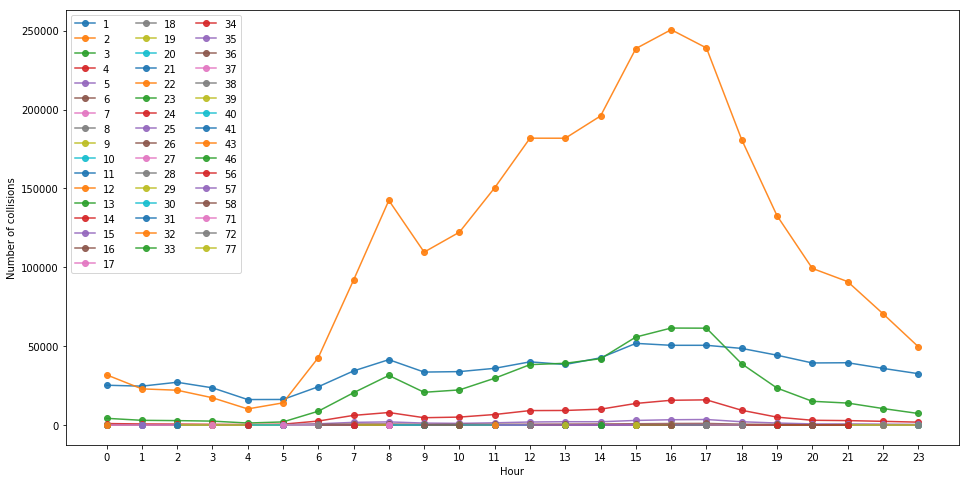

In [98]:
#Number of vehicles involved in collisions at different hours
hour1 = df4.groupby(['c_hour','c_vehs']).size().unstack()
hour1.plot(figsize=(16,8),style='o-',alpha=0.9)
plt.xticks(range(0,24),range(0,24))
plt.xlabel('Hour')
plt.ylabel('Number of collisions')
plt.legend(ncol=3);

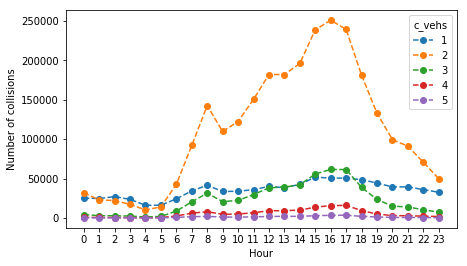

In [99]:
#Slice the data into only visualizing c_vehs=1-5 
c = hour1.iloc[:,0:5]
c.plot(style='o--',figsize=(7,4))
plt.xlabel('Hour')
plt.ylabel('Number of collisions')
plt.xticks(range(0,24),range(0,24));

### 10.2) Number of Vehicles Involved in Collision & Collision Severity 
c_sev == 1 (fatal)  
c_sev == 2 (non-fatal)

In [100]:
#Relationship between number of vehicles involved in collision and Collision severity

df5 = df_c.loc[:,['c_vehs','c_sev']]
vehs_sev = df5.groupby(['c_vehs','c_sev']).size().unstack()
vehs_sev.index = vehs_sev.index.astype(str)
vehs_sev

c_sev,1,2
c_vehs,,
1,24399.0,826007.0
2,35495.0,2654269.0
3,6997.0,549297.0
...,...,...
71,57.0,NaN
72,NaN,121.0
77,80.0,116.0


C:\Users\rynh\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


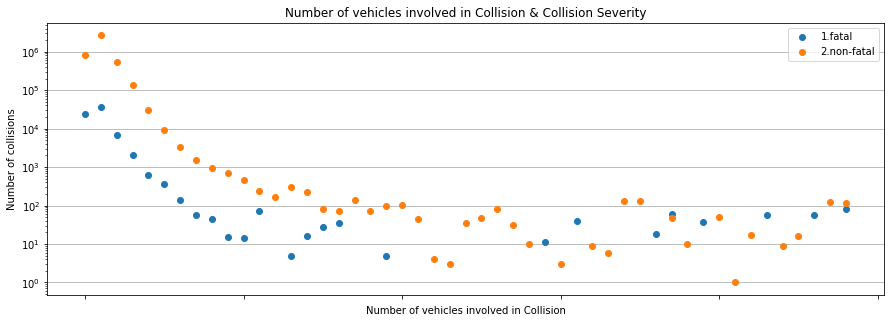

In [101]:
#Plot the new dataframe in logarithm, since the gap between numbers are huge.
vehs_sev.plot(logy=True,style = 'o', figsize=(15,5),
              title = 'Number of vehicles involved in Collision & Collision Severity')
plt.grid(axis='y')
plt.legend(['1.fatal','2.non-fatal'])
plt.xlabel('Number of vehicles involved in Collision') 
plt.ylabel('Number of collisions');

### 10.3) Number of Vehicles Involved in Collision & Collision Configuration

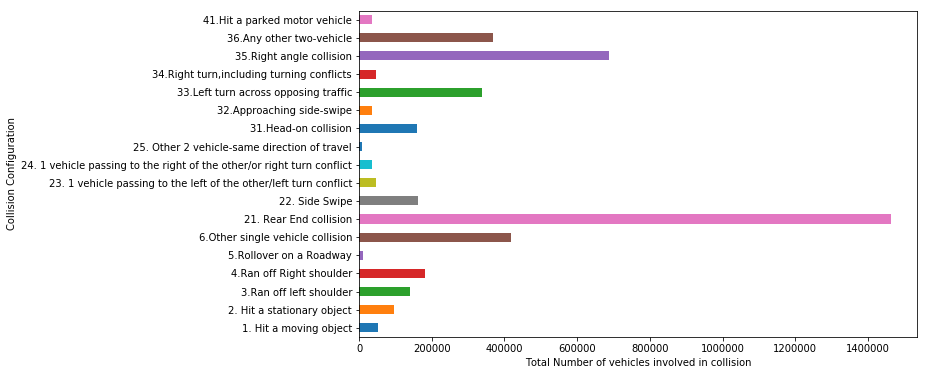

In [102]:
#Total Number of vehicles involved in collision & Collision configuration
conf = ['1. Hit a moving object','2. Hit a stationary object',
        '3.Ran off left shoulder','4.Ran off Right shoulder','5.Rollover on a Roadway',
        '6.Other single vehicle collision', '21. Rear End collision', '22. Side Swipe',
        '23. 1 vehicle passing to the left of the other/left turn conflict',
        '24. 1 vehicle passing to the right of the other/or right turn conflict',
        '25. Other 2 vehicle-same direction of travel','31.Head-on collision',
        '32.Approaching side-swipe','33.Left turn across opposing traffic',
        '34.Right turn,including turning conflicts','35.Right angle collision',
        '36.Any other two-vehicle','41.Hit a parked motor vehicle']

vehs_conf = df_c.groupby('c_conf')['c_vehs'].count().sort_index(ascending=True)

vehs_conf.plot(figsize=(10,6), kind='barh', rot=0)
plt.xlabel('Total Number of vehicles involved in collision')
plt.ylabel('Collision Configuration')
plt.yticks(np.arange(0,18),conf);

In [103]:
#Number of vehicles involved in each collision configuration
df6 = df_c.loc[:,['c_vehs','c_conf']].groupby(['c_conf','c_vehs']).size().unstack().fillna(0)
df6.index = df6.index.astype(str)
df6

c_vehs,1,2,3,4,5,6,7,8,9,10,...,40,41,43,46,56,57,58,71,72,77
c_conf,,,,,,,,,,,,,,,,,,,,,
1,48780.0,3772.0,589.0,136.0,75.0,12.0,0.0,14.0,19.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,93330.0,1458.0,361.0,53.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,133237.0,5365.0,1252.0,393.0,87.0,39.0,35.0,2.0,1.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,5056.0,604415.0,65289.0,9753.0,1671.0,263.0,118.0,28.0,0.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,329257.0,33021.0,4452.0,773.0,136.0,56.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,5.0,25731.0,7277.0,1934.0,563.0,169.0,70.0,69.0,3.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


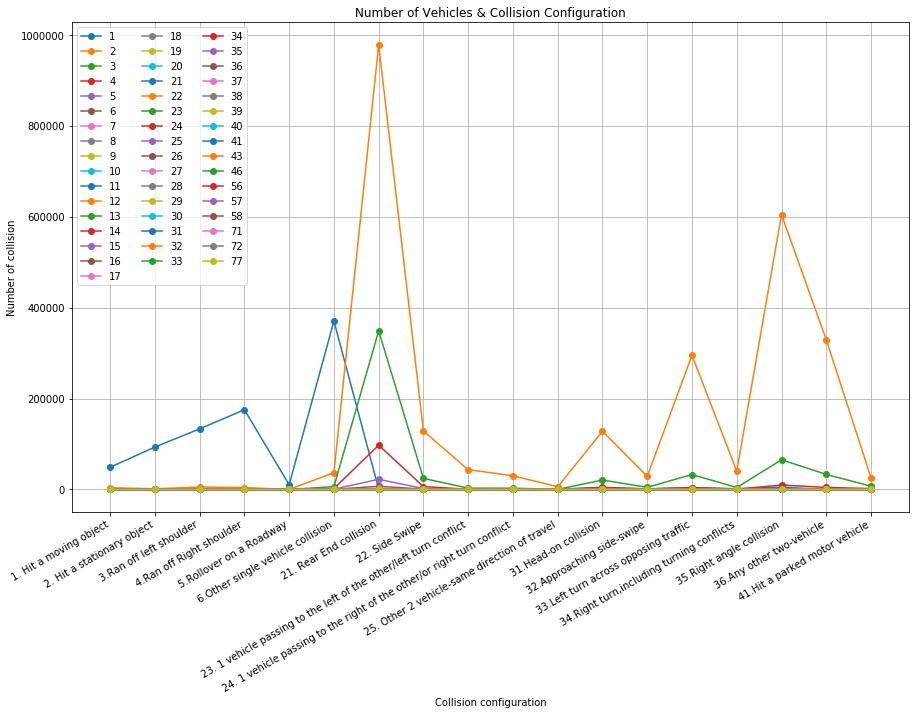

In [104]:
#Visualize the result
df6.plot(style = 'o-',figsize =(15,9),title='Number of Vehicles & Collision Configuration')
plt.xticks(np.arange(0,18),conf,rotation=30,ha='right')
plt.grid()
plt.xlabel('Collision configuration')
plt.ylabel('Number of collision')
plt.legend(ncol=3);

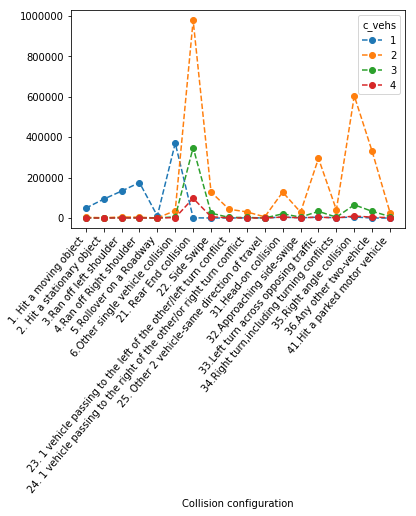

In [105]:
#Select 1-4 number of vehicles involved in collision to
# visualize its relationship with collision configuration
d = df6.iloc[:,0:4]
d.plot(style='o--')
plt.xlabel('Collision configuration')
plt.xticks(np.arange(0,18),conf,rotation=50,ha='right');

---
### 11. Collision Configuration
### 11.1) Collision Configuration & Date

In [106]:
#Analyze the relationship between collision configuration over date
df7 = df_c.loc[:,['date','c_conf']]
configuration = df7.groupby(['date','c_conf']).size().unstack()
configuration

c_conf,1,2,3,4,5,6,21,22,23,24,25,31,32,33,34,35,36,41
date,,,,,,,,,,,,,,,,,,
1999-01,2546,317,777,862,34,319,7550,1306,165,162,21,1672,227,3608,2336,2430,57,113
1999-02,2065,295,664,794,72,305,6317,637,195,104,11,1015,167,3102,1641,2053,33,99
1999-03,2209,273,633,800,57,375,7476,857,141,119,12,963,129,3405,1802,2275,55,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-10,104,521,535,651,36,1727,7259,715,187,171,39,491,133,1614,105,3264,2162,171
2014-11,100,707,673,939,20,2044,6381,666,170,126,63,794,193,1623,88,2845,1813,141
2014-12,79,632,732,908,19,1786,5889,542,192,158,52,721,272,1640,95,2865,1811,129


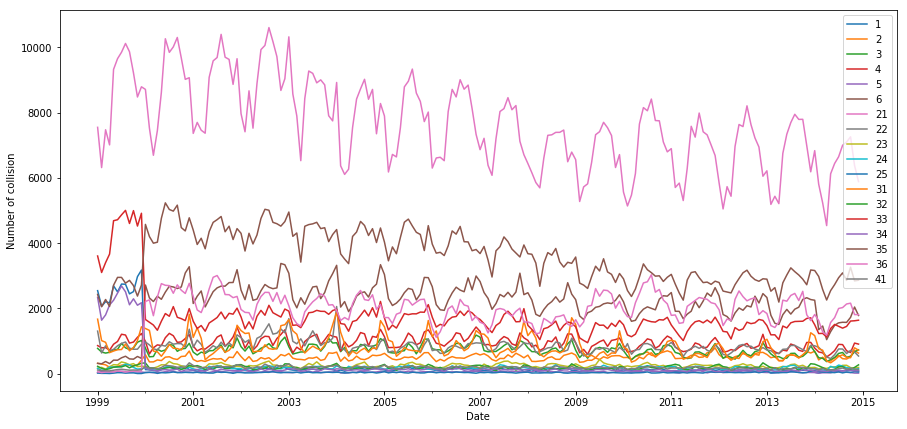

In [107]:
configuration.plot(style='',figsize=(15,7))
plt.legend(loc=1)
plt.xlabel('Date')
plt.ylabel('Number of collision');

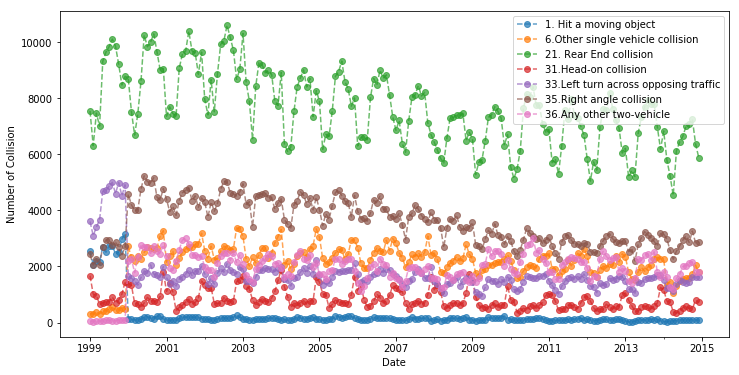

In [108]:
#Select top 5 frequest configuration collision and plot the data
confi = ['1. Hit a moving object','6.Other single vehicle collision',
         '21. Rear End collision','31.Head-on collision',
         '33.Left turn across opposing traffic',
         '35.Right angle collision','36.Any other two-vehicle']
e = configuration[[1,6,21,31,33,35,36]]
e.plot(figsize=(12,6),style='o--',alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Number of Collision')
plt.legend(confi);

### 11.2) Collision Configuration & Collision Severity

In [109]:
#Analyze the relationship between collision configuration and collision severity
df8 = df_c.loc[:,['c_conf','c_sev']]
conf_sev = df8.groupby(['c_conf','c_sev']).size().unstack()
conf_sev.index = conf_sev.index.astype(str)
conf_sev

c_sev,1,2
c_conf,,
1,1388,52009
2,2454,92750
3,5384,135072
...,...,...
35,9490,677180
36,2305,365392
41,678,35174


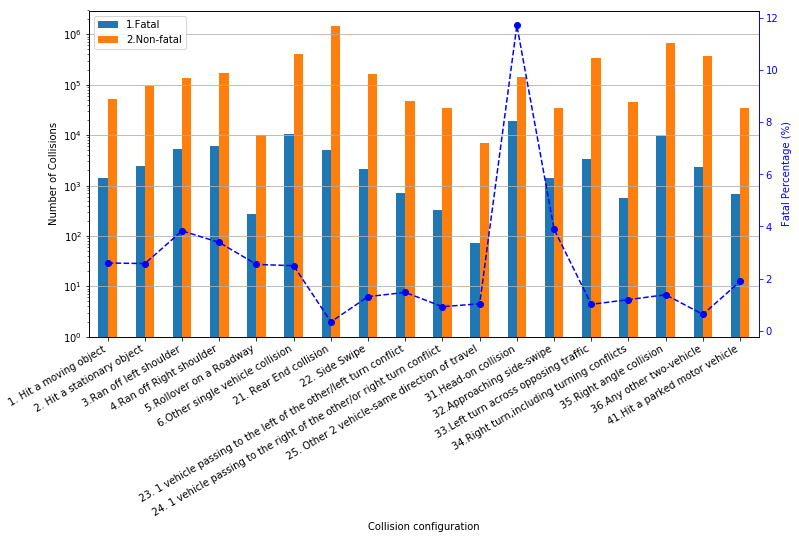

In [110]:
#Visualize the results
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

conf_sev.plot(kind='bar',rot=30,log=True,style='o--',figsize=(12,6),ax=ax1)
ax1.set_ylabel('Number of Collisions')
ax1.set_xlabel('Collision configuration')
ax1.set_xticklabels(conf,ha='right')
ax1.grid(axis='y')
ax1.legend(['1.Fatal','2.Non-fatal'])

se1 = conf_sev[1]/(conf_sev[1]+conf_sev[2])*100
se1.plot(c='b', style='o--', ax=ax2)
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')
plt.xticks(np.arange(0,18),conf,rotation=50,ha='right')
plt.xlim(-0.5,17.5);

---
### 12. Person Position
### 12.1) Person Position & Severity

In [111]:
#Analyze the relationship between person position and collision severity
position = ['11.Driver','12. Front row, center','13.Front row: right outboard',
            '21.Second row:left outboard','22.Second row:center',
            '23.Second row:right outboard','31.Third row:left outboard',
            '32.Third row:center','33.Third row:right outboard',
            '96.Unknown occupant','97.Sitting on someone’s lap',
            '98.Outside passenger compartment','99.Pedestrian']
df9 = df_c.loc[:,['p_psn','c_sev']]
psn_sev = df9.groupby(['p_psn','c_sev']).size().unstack()
psn_sev

c_sev,1,2
p_psn,,
11,41372,2739810
12,1443,68275
13,13486,763592
...,...,...
97,12,156
98,96,3772
99,2330,85488


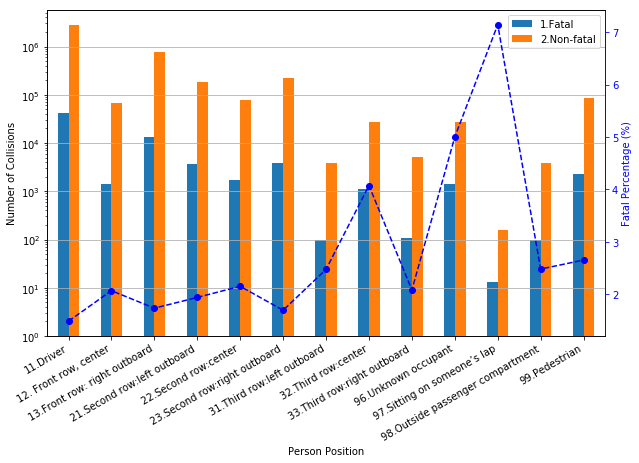

In [112]:
#Visualize the result
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

psn_sev.plot(kind='bar',rot=30,log=True,style='o--',figsize=(10,6),ax=ax1)
ax1.set_ylabel('Number of Collisions')
ax1.set_xlabel('Person Position')
ax1.set_xticklabels(position,ha='right')
ax1.grid(axis='y')
ax1.legend(['1.Fatal','2.Non-fatal'])

se1 = psn_sev[1]/(psn_sev[1]+psn_sev[2])*100
se1.plot(c='b', style='o--', ax=ax2)
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')
plt.xticks(np.arange(0,13),position,rotation=40,ha='right')
plt.xlim(-0.5,12.5);

### 12.2) Person Position & Configuration 

In [113]:
#Relationship between Person position and collision configuration
df10 = df_c.loc[:,['p_psn','c_conf']]
psn_conf = df10.groupby(['c_conf','p_psn']).size().unstack().fillna(0)
psn_conf.index = psn_conf.index.astype(str)
psn_conf

p_psn,11,12,13,21,22,23,31,32,33,96,97,98,99
c_conf,,,,,,,,,,,,,
1,27522.0,878.0,8067.0,1909.0,824.0,2149.0,39.0,498.0,60.0,276.0,1.0,50.0,11124.0
2,67842.0,1188.0,16182.0,3369.0,1232.0,4270.0,33.0,28.0,41.0,498.0,3.0,101.0,417.0
3,88376.0,3893.0,27472.0,6745.0,3017.0,7657.0,233.0,593.0,263.0,2015.0,4.0,111.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,457747.0,11976.0,126655.0,29296.0,11948.0,36465.0,675.0,3862.0,915.0,5996.0,23.0,479.0,633.0
36,240980.0,4301.0,68791.0,18511.0,7803.0,22951.0,0.0,3102.0,1.0,19.0,28.0,421.0,789.0
41,22623.0,952.0,6476.0,1419.0,603.0,1756.0,22.0,225.0,28.0,510.0,24.0,174.0,1040.0


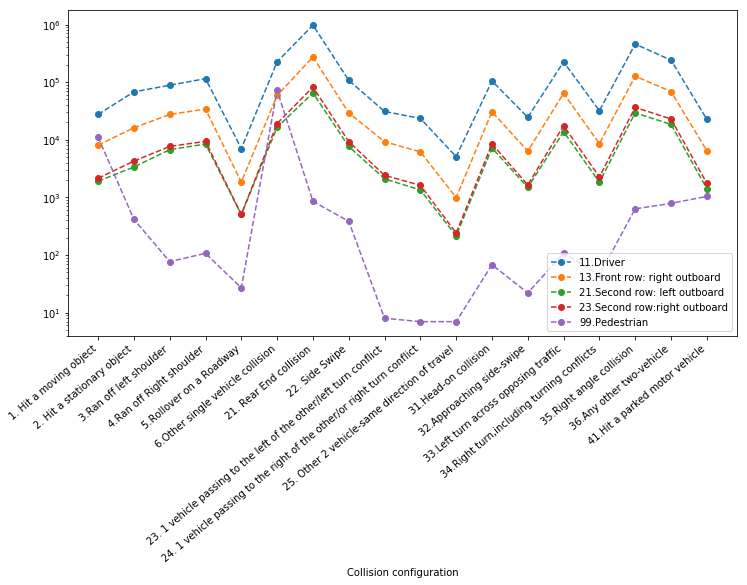

In [114]:
#Visualize the result
psn = ['11.Driver','13.Front row: right outboard','21.Second row: left outboard',
       '23.Second row:right outboard','99.Pedestrian']
f = psn_conf.iloc[:,[0,2,3,5,12]]
f.plot(logy=True,style='o--',figsize=(12,6))
plt.legend(psn)
plt.xlabel('Collision configuration')
plt.xticks(np.arange(0,18),conf,rotation=40,ha='right');

### 13. Safety Device Used & Severity

In [115]:
#Relationship between safety device used over time
df11 = df_c.loc[:,['date','p_safe']]
saf_date = df11.groupby(['date','p_safe']).size().unstack()
saf_date

p_safe,1,2,9,10,11,12,13
date,,,,,,,
1999-01,1101.0,22557.0,84.0,NaN,NaN,37.0,723.0
1999-02,1050.0,17809.0,65.0,2.0,NaN,25.0,618.0
1999-03,1182.0,19627.0,99.0,NaN,NaN,44.0,719.0
...,...,...,...,...,...,...,...
2014-10,729.0,18107.0,473.0,1.0,NaN,321.0,254.0
2014-11,532.0,18153.0,171.0,1.0,NaN,249.0,280.0
2014-12,544.0,17356.0,82.0,1.0,NaN,282.0,257.0


C:\Users\rynh\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


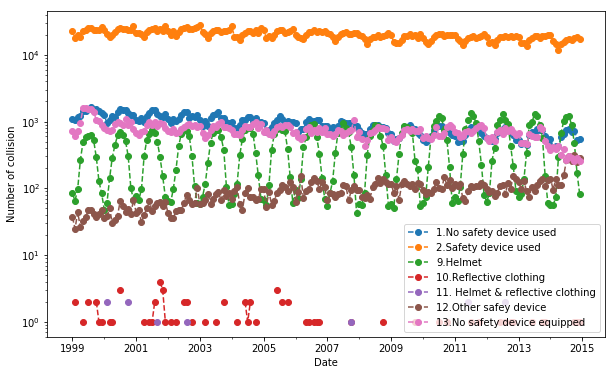

In [116]:
#Visualize the result
#13. No safety device equipped => eg. buses
safety = ['1.No safety device used','2.Safety device used','9.Helmet',
          '10.Reflective clothing','11. Helmet & reflective clothing',
          '12.Other safey device','13.No safety device equipped']
saf_date.plot(logy=True, style='o--',figsize=(10,6))
plt.legend(safety, loc=4)
plt.ylabel('Number of collision')
plt.xlabel('Date');

In [117]:
#Relationship between safety device used and collision severity
df12 = df_c.loc[:,['p_safe','c_sev']]
saf_sev = df12.groupby(['p_safe','c_sev']).size().unstack().fillna(0)
saf_sev.index = saf_sev.index.astype(str)
saf_sev

c_sev,1,2
p_safe,,
1,14791.0,159975.0
2,48835.0,3816516.0
9,2657.0,80146.0
...,...,...
11,0.0,11.0
12,612.0,17003.0
13,3848.0,136992.0


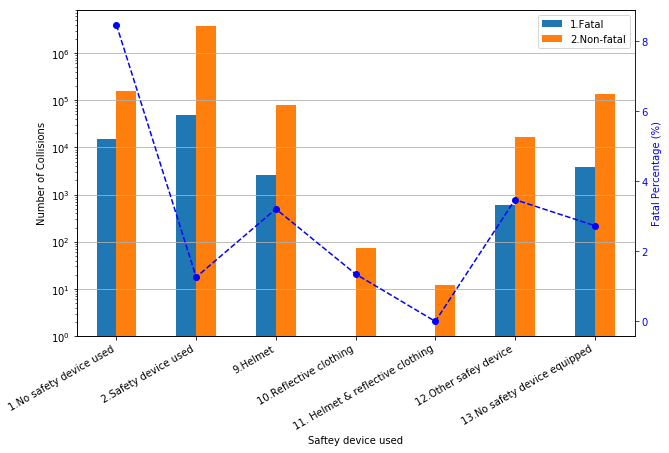

In [118]:
#Visualize the result
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

saf_sev.plot(kind='bar',rot=30,log=True,style='o--',figsize=(10,6),ax=ax1)
ax1.set_ylabel('Number of Collisions')
ax1.set_xlabel('Saftey device used')
ax1.set_xticklabels(safety,ha='right')
ax1.grid(axis='y')
ax1.legend(['1.Fatal','2.Non-fatal'])

se1 = saf_sev[1]/(saf_sev[1]+saf_sev[2])*100
se1.plot(c='b', style='o--', ax=ax2)
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')
plt.xticks(range(0,7),safety)
plt.xlim(-0.5,6.5);

## The End